---
title: "Causal Inference of Labor Market Inequality Using PGM: A multidimensional analysis of unemployment rate and durations"
author:
    name: Mengjia Wei
    email: mw1296@georgetown.edu
    affiliation: Georgetown University
keywords:
  - PGM
  - Unemployment Rate
  - Unemployment Durations
  - Causal Inference
abstract: |
  In its revised report released on July 31, 2025, the U.S. Bureau of Labor Statistics (BLS) reported a sharp slowdown in job creation beginning in May, signaling heightened uncertainty and growing concerns about the overall health of the U.S. labor market. This study investigates the causal relationships between race, industry and unemployment rates in the United States, applying probabilistic graphical modeling (PGM) to uncover latent dependency structures across demographic and industry variables. Using a PGM framework, we extend this approach to labor market data by constructing conditional dependence networks across two key dimensions: group attributes (race and industry) and time (2024 vs. 2025). Specifically, the study examines recent college graduates (ages 22–24) relative to older individuals (25+), comparing their unemployment rates across 2024 and 2025. This study first examined the race effect on the unemployment rate disparitu. The industry-specific unemployment rate dynamics focuses on [retail] [] and [Leisure and hospitality] sectors. This analysis seeks to identify whether certain groups—such as Black labor force and [Retail Industry]—face higher or lower unemployment, providing a more comprehensive view of labor market hardship. The model estimates the strength and direction of probabilistic dependencies using Bayesian structure learning algorithms, based on labor force aggregated data from BLS CPS datasets. The results indicate that [conclusion1]. Additionally, the [retail], [], and [technology] industries experienced increased unemployment rates between the year of 2015 and the year of 2025, with respective changes of [ ], [ ], and [ ] percentage points. The PGM framework reveals significant interactive effects between race and industry on unemployment, particularly among Black workers and the [retail and hospitality] sectors. These findings contribute to the growing literature that leverages PGMs for social inference (e.g., Li et al., 2022), highlighting the model’s potential for uncovering structural labor inequalities over time and across population subgroups.
plain-language-summary: |
  TBD
key-points:
  - TBD
  - TBD
date: last-modified
bibliography: references.bib
citation:
  container-title: Georgetown Univeristy DSAN 5650 Journal
number-sections: true
jupyter: python3
---

## Introduction

The interplay of demographic characteristics and labor market dynamics consistently reveals significant disparities in unemployment rates. Decades of research reveal a persistent relationship between race, gender, and unemployment, evident across diverse economic cycles. Though the Black unemployment rate fell to a historic low of 6.1% in 2019, it was still twice as high as the White unemployment rate of 3.0%, as @ValerieWilson2022 observed. These disparities are further magnified at the intersection of race and gender. For instance, Black men faced a 6.1% unemployment rate in February 2024, notably higher than Black women at 4.4%. Similarly, Hispanic women's unemployment rate increased to 5.0% in February 2024, while Hispanic men experienced a decrease to 4.0% (@Joseph2024). Native American men also experienced higher unemployment (10%) than Native American women (7%) in 2022. Industry-specific analyses similarly highlight divergent unemployment trends. The Leisure and Hospitality sector reported the highest unemployment rate at 6.0% in 2024, an increase from 5.5% in 2023. Similarly, Wholesale and Retail Trade experienced elevated unemployment, reaching 4.7% in October 2024, up from 4.0% in 2023. Conversely, Financial Activities maintained a significantly lower unemployment rate of 1.9% (@Oberlo2024). 

Research from the U.S. Bureau of Labor Statistics consistently shows longer unemployment spells in sectors such as Manufacturing and Construction, while industries demanding specialized skills like Education and Health Services exhibit shorter durations. Study by @YiLiChienandPaulMorris reveals negative correlation between the unemployment rate and duration. Such variations in both the rate and duration of unemployment underscore complex interactions among race, gender, age, and industry.

@TOIEducation2025 published that the labor market for recent college graduates has "deteriorated noticeably" in the first quarter of 2025. The unemployment rate for this cohort (ages 22-27) ranged from 5.5% to 7.1%, exceeding the overall national average of 4.1-4.2%, with Anthropology (9.4%), Physics (7.8%), and Computer Engineering (7.5%) showing among the highest rates. 

![Unemployment Rate of Recent College Graduates](images/unemployment_rate_recent_graduate.png){#fig-graduates}

Although the Federal Open Market Committee (FOMC) reported a low overall unemployment rate for June 2025 (Based on the U.S. Bureau of Labor Statistics (BLS) revised job creation data released on July 31, 2025, a marked decline in job creation has been observed beginning in May, raising substantial concerns regarding the stability of the U.S. labor market.), recent data clearly indicate a noticeable uptick in the unemployment rate for the 22-27 age group since March, reaching 2021 levels and particularly affecting recent college graduates (@fig-graduates). 

## Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#| label: tbl-monthly-unemployment-rate-race
#| tbl-cap: BLS 2015-2025 Monthly Unemployment Rate By Race

# Data pre-processing - part1: Merge monthly unemployment rates by different demographics excel files downlaoded from BLS website
import pandas as pd
import os
#os.getcwd()

def create_df_race(folder_path, demographic_type, id_vars, var_name, value_name):
    merged_df = pd.DataFrame()
    file_name = [f.removesuffix('.xlsx') for f in os.listdir(os.path.join("../data", folder_path)) if f.endswith('.xlsx')]
    for f in file_name:
        file_path = os.path.join("../data", folder_path, f + ".xlsx")    
        df = pd.read_excel(file_path)
        rows = df[df.iloc[:,0]=='Year'].index[0]+2-1
        df = pd.read_excel(file_path, skiprows=rows)
        df_long = df.melt(id_vars=id_vars, var_name=var_name, value_name=value_name)
        df_long[demographic_type] = f
        merged_df = pd.concat([merged_df, df_long], ignore_index=True)
    return merged_df

folder_path_list = ["unemployment_rate_by_race",
             "unemployment_rate_by_sex",
             "unemployment_rate_by_industry",
             "unemployment_rate_by_age",
            "unemployment_rate_by_education_attainment"]

demographic_type_list = ['Race',
                    'Sex',
                    'Industry',
                    'Age',
                    'Education_attainment']

d_vars="Year"
var_name="Month"
value_name="Unemployment_rate"

df_dic = {}
for i in range(0, len(folder_path_list)):
    folder_path = folder_path_list[i]
    demographic_type=demographic_type_list[i]
    merged_df = create_df_race(folder_path, demographic_type, "Year", "Month", "Unemployment_rate")
    df_dic[demographic_type] = merged_df

display(df_dic['Race'].head(10).style.hide(axis='index').format({'Unemployment_rate':'{:.2f}'}))

#list(df_dic.values())[0]

Year,Month,Unemployment_rate,Race
2015,Jan,5.30,white
2016,Jan,4.70,white
2017,Jan,4.70,white
2018,Jan,3.90,white
2019,Jan,4.00,white
2020,Jan,3.50,white
2021,Jan,6.20,white
2022,Jan,3.90,white
2023,Jan,3.50,white
2024,Jan,3.80,white


Data from the U.S. Bureau of Labor Statistics (BLS) 2015 to 2025 monthly aggregated unemployment rate by races. This dataset is used to analyze the race effect on unemployment along with the monthly unemployment rate aggregated data by race (@tbl-monthly-unemployment-rate-race).

In [3]:
# Data pre-processing - part2: Load and process monthly unemployment overall file
df_overall = pd.read_excel("../data/unemployment_rate_monthly_data.xlsx", skiprows=11)
df_overall_long = df_overall.melt(id_vars="Year", var_name="Month", value_name="Unemployment_rate")

In [4]:
#| label: tbl-survey-data-jun2025
#| tbl-cap: BLS June 2025 Labor Force Survey Data

# Data pre-processing - part3: Load and process Jun 2025 BLS labor survey data
# process the survey data
import numpy as np
df_survey_jun = pd.read_csv("../data/survey_data/jun_2025.csv")
df_survey_jun.columns= ["sex","education_attainment","race","age","employment_status",
                        "unmployment_duration","industry","occupation","industry_detailed",
                        "occupation_detailed"]
## create mapping tables to convert the demographic codes to the descriptions
sex_mapping = {
        1: "male",
        2: "female"
}

education_attainment_codes = list(np.arange(31,47))
education_attainment_values = [
        'less_than_high_school',
		'less_than_high_school',
		'less_than_high_school',
        'less_than_high_school',
'less_than_high_school',
'less_than_high_school',
'less_than_high_school',
'less_than_high_school',
'high_school',
'some_college_or_associate_degree',
'some_college_or_associate_degree',
'some_college_or_associate_degree',
'bachelors_degree',
'masters_degree',
'professional_degree',
'doctoral_degree'
    ]    
education_attainment_mapping=dict(zip(education_attainment_codes,education_attainment_values))

race_codes = list(np.arange(1,27))
race_values = [
        "white",
        "black",
        "other",
        "asian"
    ] + ["other"] * 22
race_mapping= dict(zip(race_codes, race_values))


employment_status_codes =[
        1,2,3,4,5,6,7
    ]
employment_status_names = [
        "employed",
        "employed",
        "unemployed",
        "unemployed",
        "not in labor force",
        "not in labor force",
        "not in labor force"
    ]
employment_status_mapping = dict(zip(employment_status_codes,employment_status_names))

industry_codes = list(np.arange(1,15))
industry_names = [
    "Agriculture, forestry, fishing, and hunting",
    "Mining",
    "Construction",
    "Manufacturing",
    "Wholesale and retail trade",
    "Transportation and utilities",
    "Information",
    "Financial activities",
    "Professional and business services",
    "Educational and health services",
    "Leisure and hospitality",
    "Other services",
    "Public administration",
    "Armed Forces"
    ]
industry_mapping = dict(zip(industry_codes, industry_names))

## Create new columns with decoded names
df_survey_jun['sex_name'] = df_survey_jun['sex'].map(sex_mapping)
df_survey_jun['race_name'] = df_survey_jun['race'].map(race_mapping)
df_survey_jun['education_attainment_name'] = df_survey_jun['education_attainment'].map(education_attainment_mapping)
df_survey_jun['employment_status_name'] = df_survey_jun['employment_status'].map(employment_status_mapping)
df_survey_jun['industry_name'] = df_survey_jun['industry'].map(industry_mapping)

## Filter out industry_name na rows
df_survey_jun = df_survey_jun[~df_survey_jun['industry_name'].isna()]

## Add columns "is_black" and "unemployment_status" for the binary model
df_survey_jun['is_black_african'] = (df_survey_jun['race_name']=='black').astype(int)

## Add column is_asian for the binary model
df_survey_jun['is_asian'] = (df_survey_jun['race_name']=='asian').astype(int)

## Add column is_asian for the binary model
df_survey_jun['is_white'] = (df_survey_jun['race_name']=='white').astype(int)

## Add column employment_status for the binary model
df_survey_jun['unemployment_status'] = (df_survey_jun['employment_status_name']=='unemployed').astype(int)

## Display the table
display(df_survey_jun.loc[:,[col for col in df_survey_jun.columns if 'name' in col or col == 'is_black_african'  or col == 'is_white'  or col == 'is_asian']].head(10).style.hide(axis='index'))

sex_name,race_name,education_attainment_name,employment_status_name,industry_name,is_black_african,is_asian,is_white
male,white,bachelors_degree,employed,Construction,0,0,1
male,white,high_school,employed,Construction,0,0,1
female,white,bachelors_degree,employed,Manufacturing,0,0,1
male,white,bachelors_degree,employed,Manufacturing,0,0,1
female,white,masters_degree,employed,Transportation and utilities,0,0,1
female,white,bachelors_degree,employed,Construction,0,0,1
male,white,high_school,employed,Wholesale and retail trade,0,0,1
female,white,bachelors_degree,employed,Professional and business services,0,0,1
male,white,less_than_high_school,employed,Professional and business services,0,0,1
female,white,high_school,employed,Educational and health services,0,0,1


Data from the U.S. Bureau of Labor Statistics (BLS) June 2025 labor force survey provide individual-level employment status and corresponding demographic information. For the purpose of this study, a subset of these relevant columns is utilized (@tbl-survey-data-jun2025). This dataset is used to sample and predict employment status using the observations in the survey data.

In [5]:
#| label: tbl-survey-data-2024-2025
#| tbl-cap: BLS 2024 - 2025 Jan - Jul Labor Force Survey Data

## Data pre-processing part3: Process monthly survey data of 2024 Jan-Jul and 2025 Jan-Jul
survey_file_names = [f.removesuffix(".csv") for f in os.listdir('../data/survey_data') if f.endswith("csv")]
cols = ['prmjind1', 'pemlr'] # keep columns industry and employment_status
survey_df = []
for s in survey_file_names:
    survey_file = pd.read_csv(os.path.join('../data/survey_data/', s + ".csv" ))
    survey_data = survey_file[cols]
    survey_data.columns=['industry','employment_status']
    survey_data['month_year'] = s
    survey_df.append(survey_data)
# Combine all into a single DataFrame
survey_df = pd.concat(survey_df, ignore_index=True)
# decode the industry and employment_status columns
survey_df['industry_name'] = survey_df['industry'].map(industry_mapping)
survey_df = survey_df[~survey_df['industry_name'].isna()]
survey_df['employment_status_description'] = survey_df['employment_status'].map(employment_status_mapping)
display(survey_df.head(10).style.hide(axis='index'))

industry,employment_status,month_year,industry_name,employment_status_description
11,1,jan_2024,Leisure and hospitality,employed
11,1,jan_2024,Leisure and hospitality,employed
10,1,jan_2024,Educational and health services,employed
5,1,jan_2024,Wholesale and retail trade,employed
4,4,jan_2024,Manufacturing,unemployed
8,1,jan_2024,Financial activities,employed
9,1,jan_2024,Professional and business services,employed
5,1,jan_2024,Wholesale and retail trade,employed
4,1,jan_2024,Manufacturing,employed
4,1,jan_2024,Manufacturing,employed


Data from the U.S. Bureau of Labor Statistics (BLS) historical monthly labor force survey provide individual-level employment status by industries. For the purpose of this study, we utilized 2024 Jan to Jul and 2025 Jan to Jun data. (@tbl-survey-data-2024-2025). This dataset is used to analyze the industry effect on unemployment rate in the recent 2 years.


## EDA
### Unemployment Rates of Differenet Races

Unemployment Rate Distribution Histograms By Race


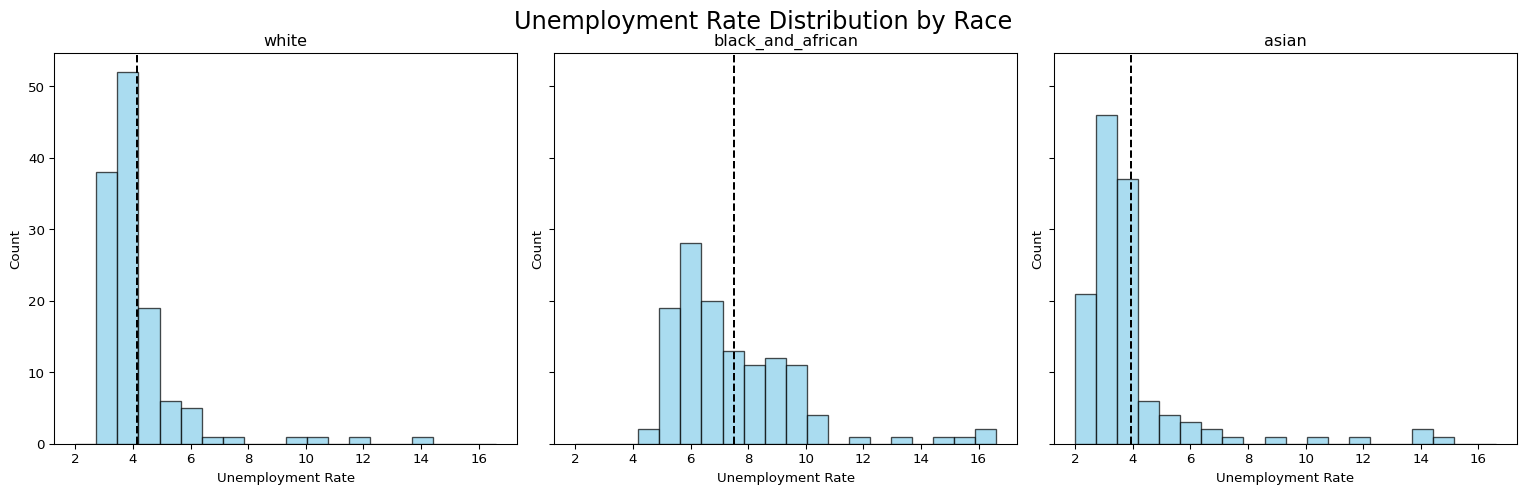

Unemployment Rate Distribution Histograms By Sex


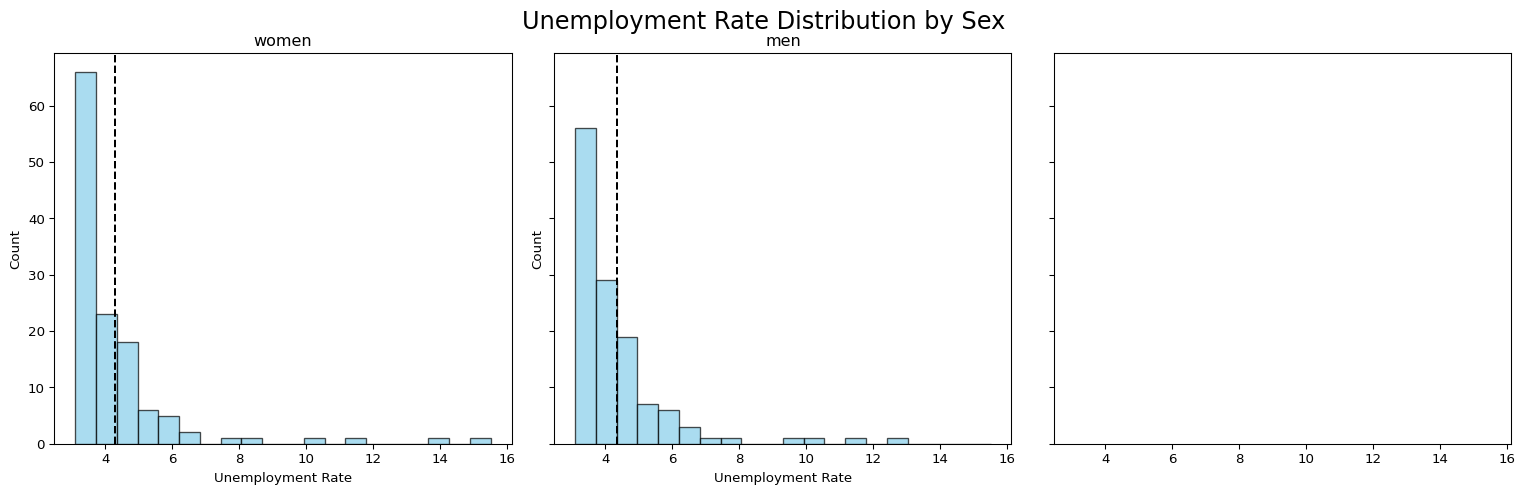

Unemployment Rate Distribution Histograms By Industry


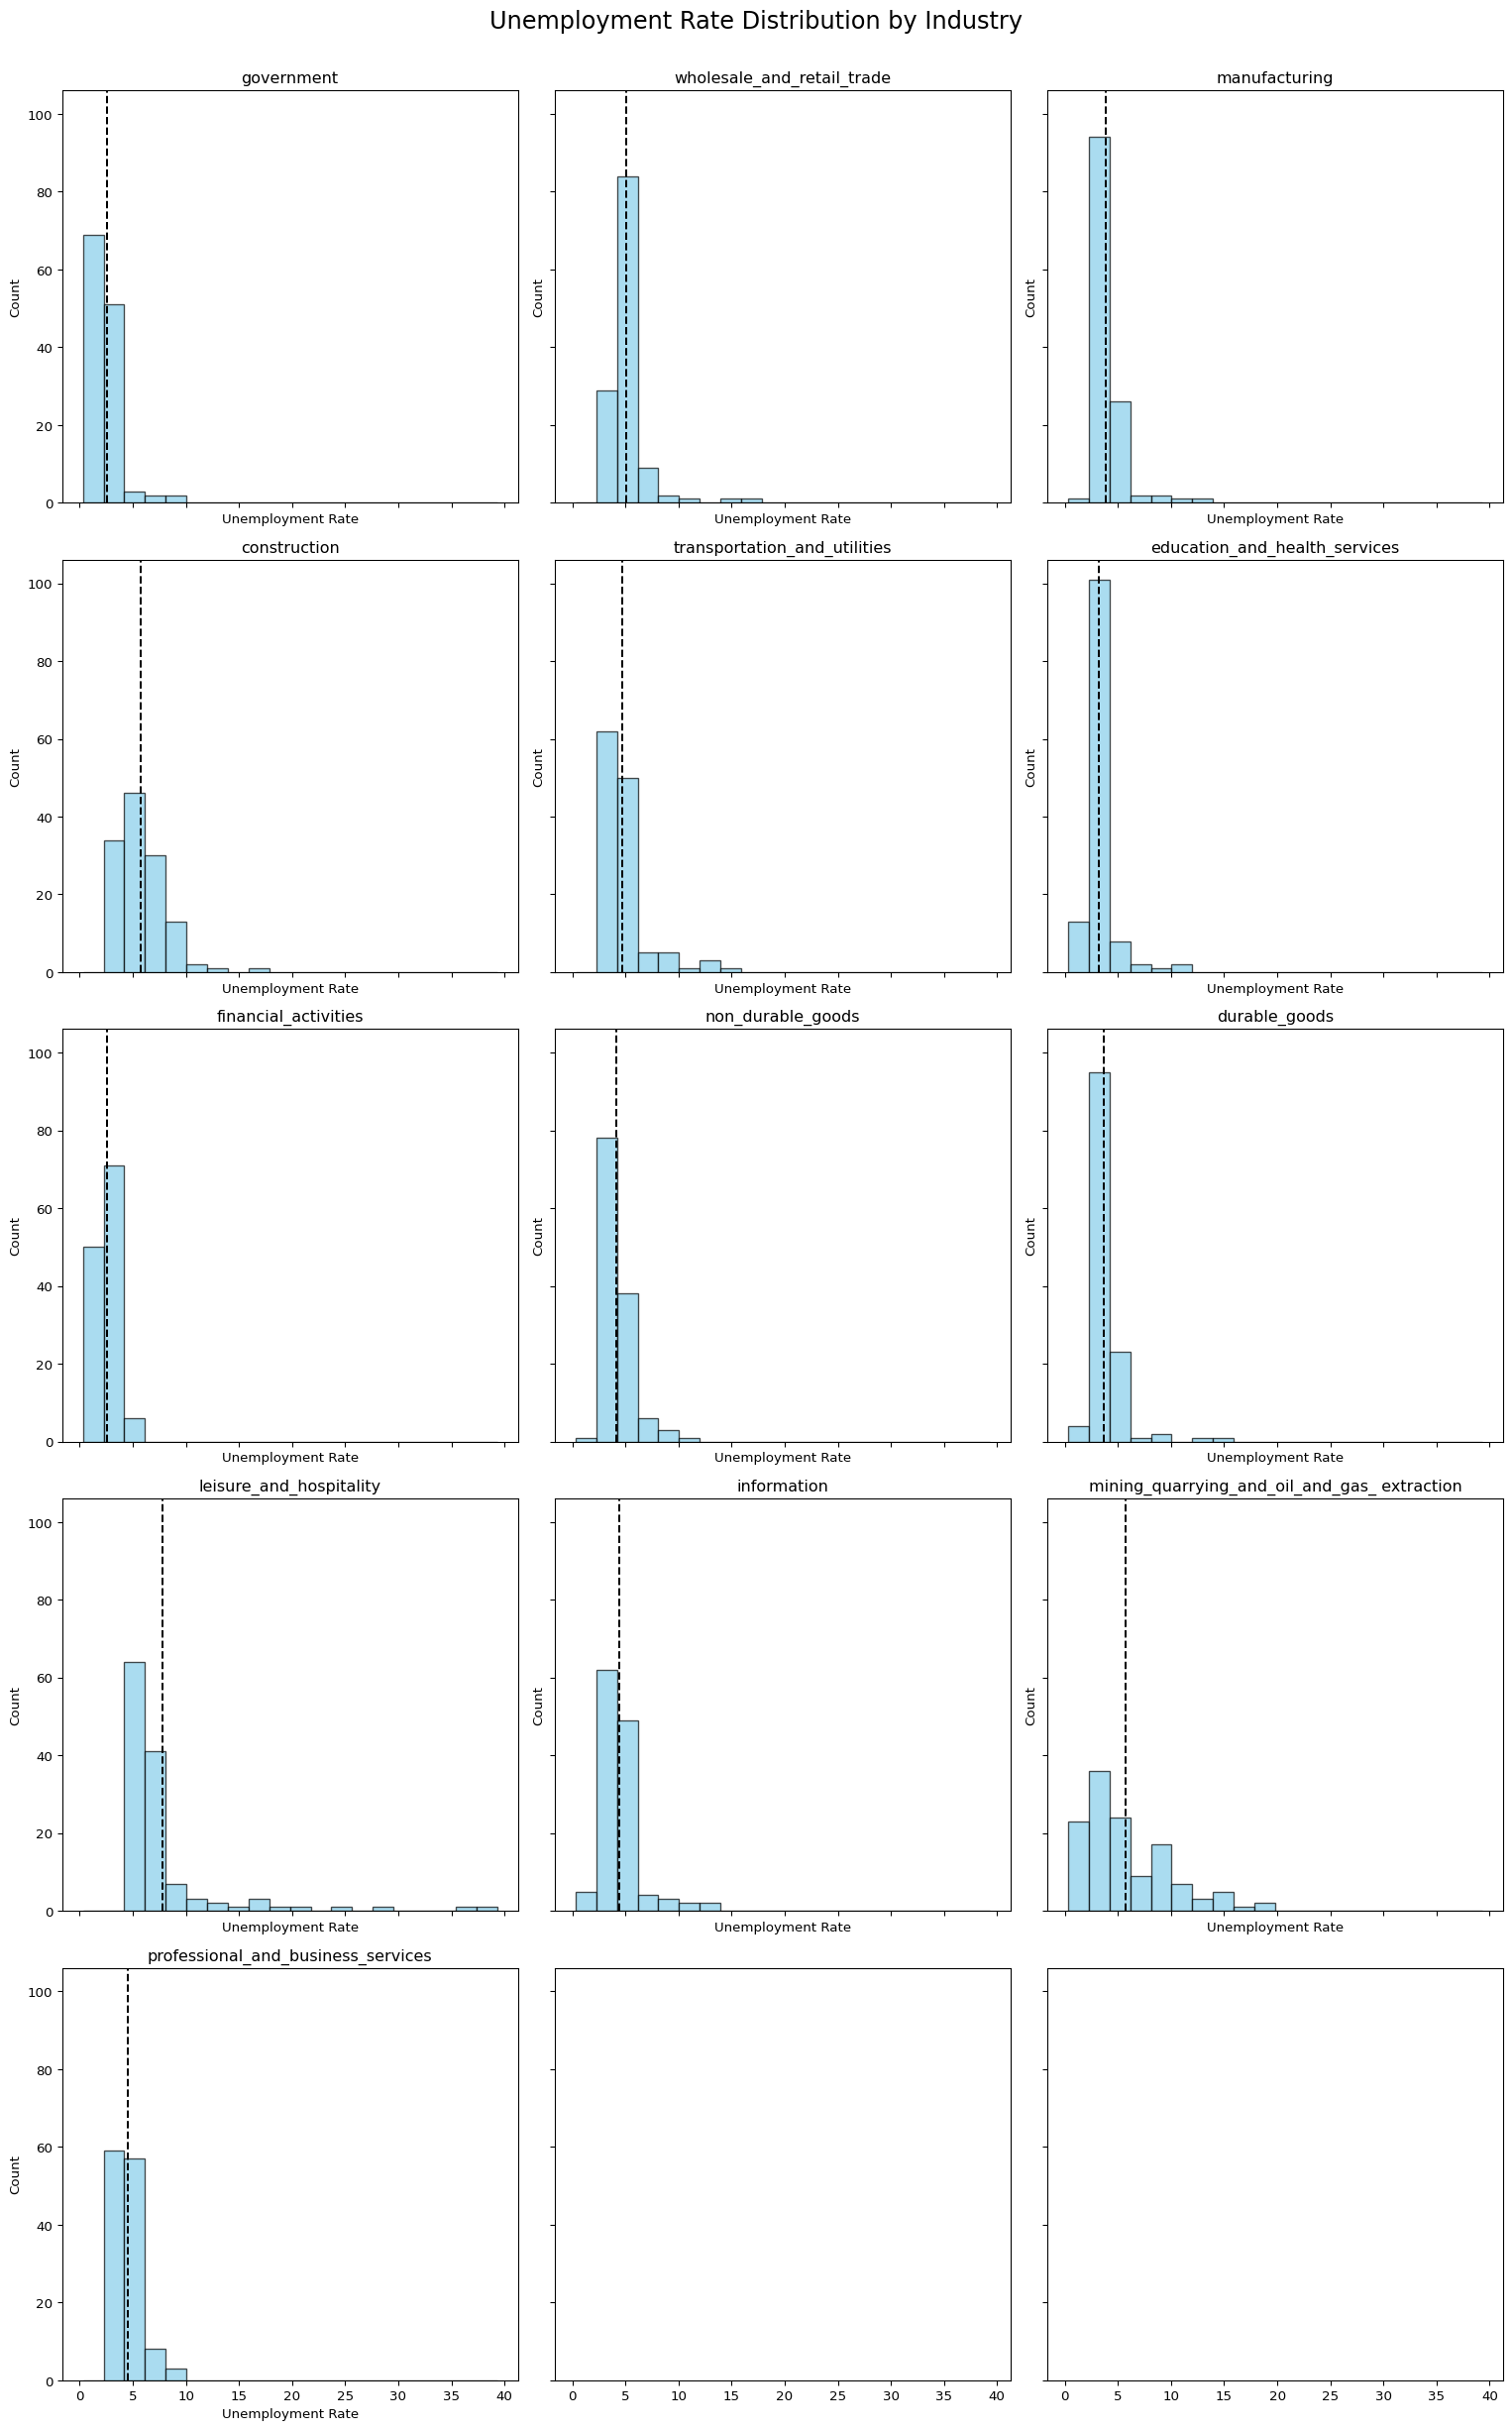

Unemployment Rate Distribution Histograms By Age


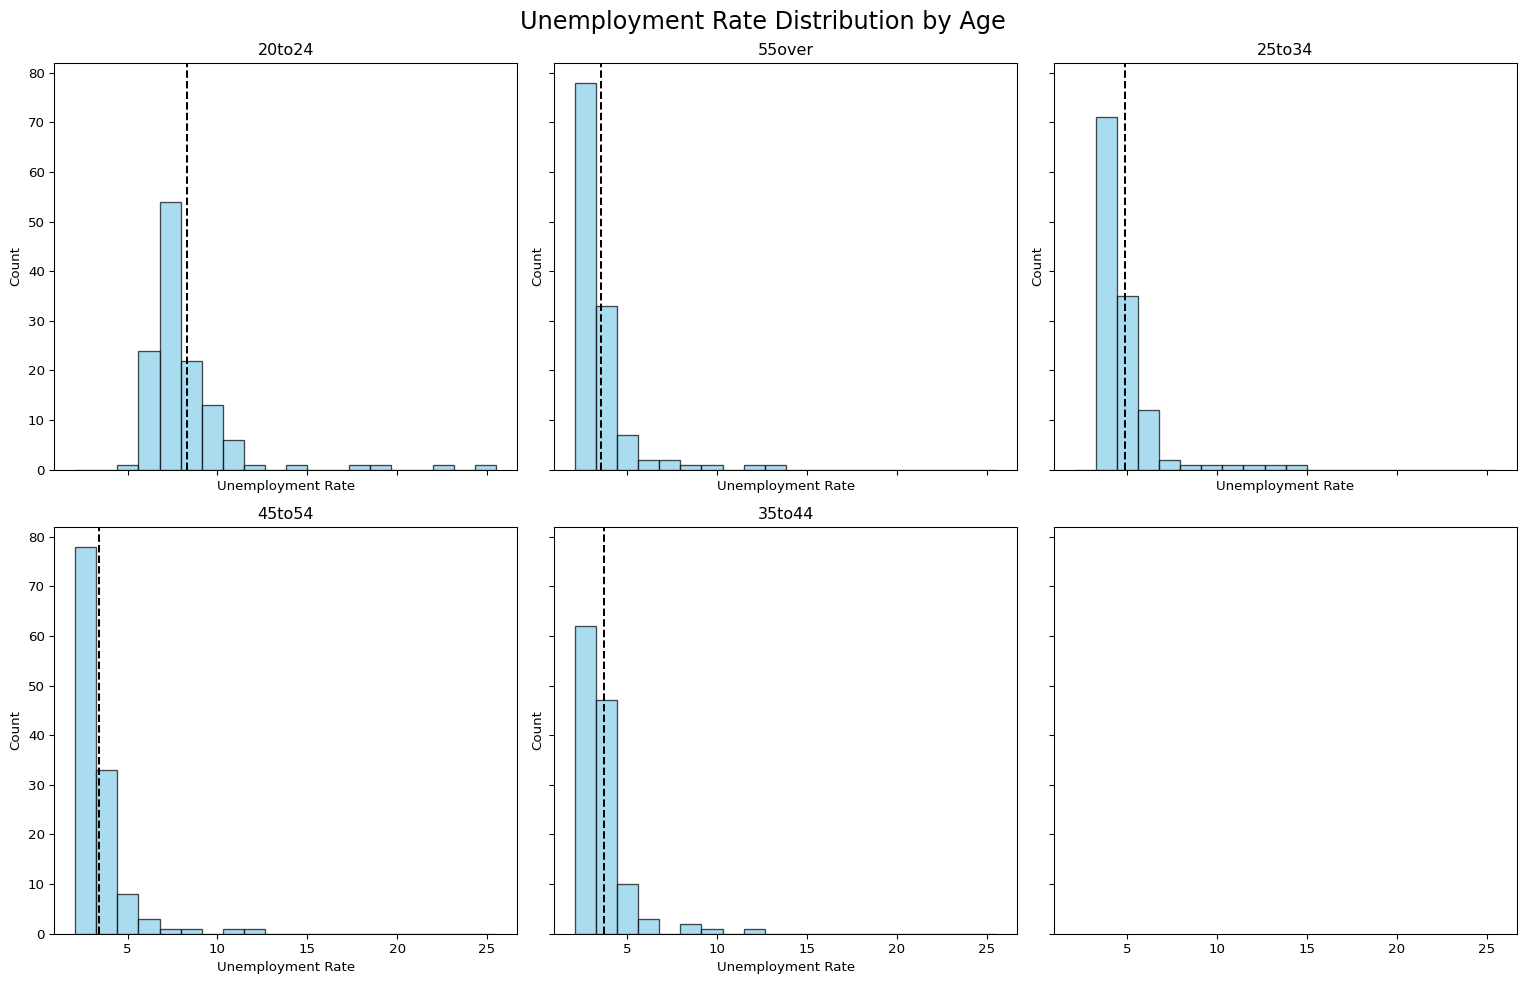

In [6]:
# Plot the distributions of unemployment stats of different demographic categories 

## 1. Plot the umemployment rate distributions by gender, age, industry, education_unattainment
import matplotlib.pyplot as plt
import numpy as np

def plot_hist(df_plot, demographic_type):
    unique_categories = df_plot[demographic_type].unique()
    num_unique_categories = len(unique_categories)
    ncol = 3
    nrow = np.int64(np.ceil(num_unique_categories/ncol))
    fig, axes = plt.subplots(ncols=ncol, nrows=nrow, sharex=True, sharey=True, figsize = (16,nrow*5))
    axes = axes.flatten()
    min_rate = df_plot['Unemployment_rate'].min()
    max_rate = df_plot['Unemployment_rate'].max()
    num_bins = 20 
    bins = np.linspace(min_rate, max_rate, num_bins + 1)
    for i, category in enumerate(unique_categories):
        ax = axes[i]
        vals = df_plot[df_plot[demographic_type]==category]['Unemployment_rate']
        ax.hist(vals, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
        ax.axvline(np.mean(vals), color = 'black', linestyle = "--")
        ax.set_title(category, fontsize=12)
        ax.set_xlabel('Unemployment Rate', fontsize=10)
        ax.set_ylabel('Count', fontsize=10)
    plt.tight_layout()
    plt.suptitle(f'Unemployment Rate Distribution by {demographic_type}', y=1.02, fontsize=18) 
    plt.show()

# Show the graphs except for the last one in order to add the ariticle label to the last grapph
for i in range(0, len(df_dic.keys())-1):
    df_plot = list(df_dic.values())[i]
    demographic_type = list(df_dic.keys())[i]
    print(f"Unemployment Rate Distribution Histograms By {demographic_type}")
    plot_hist(df_plot, demographic_type)


Unemployment Rate Distribution Histograms By Education_attainment


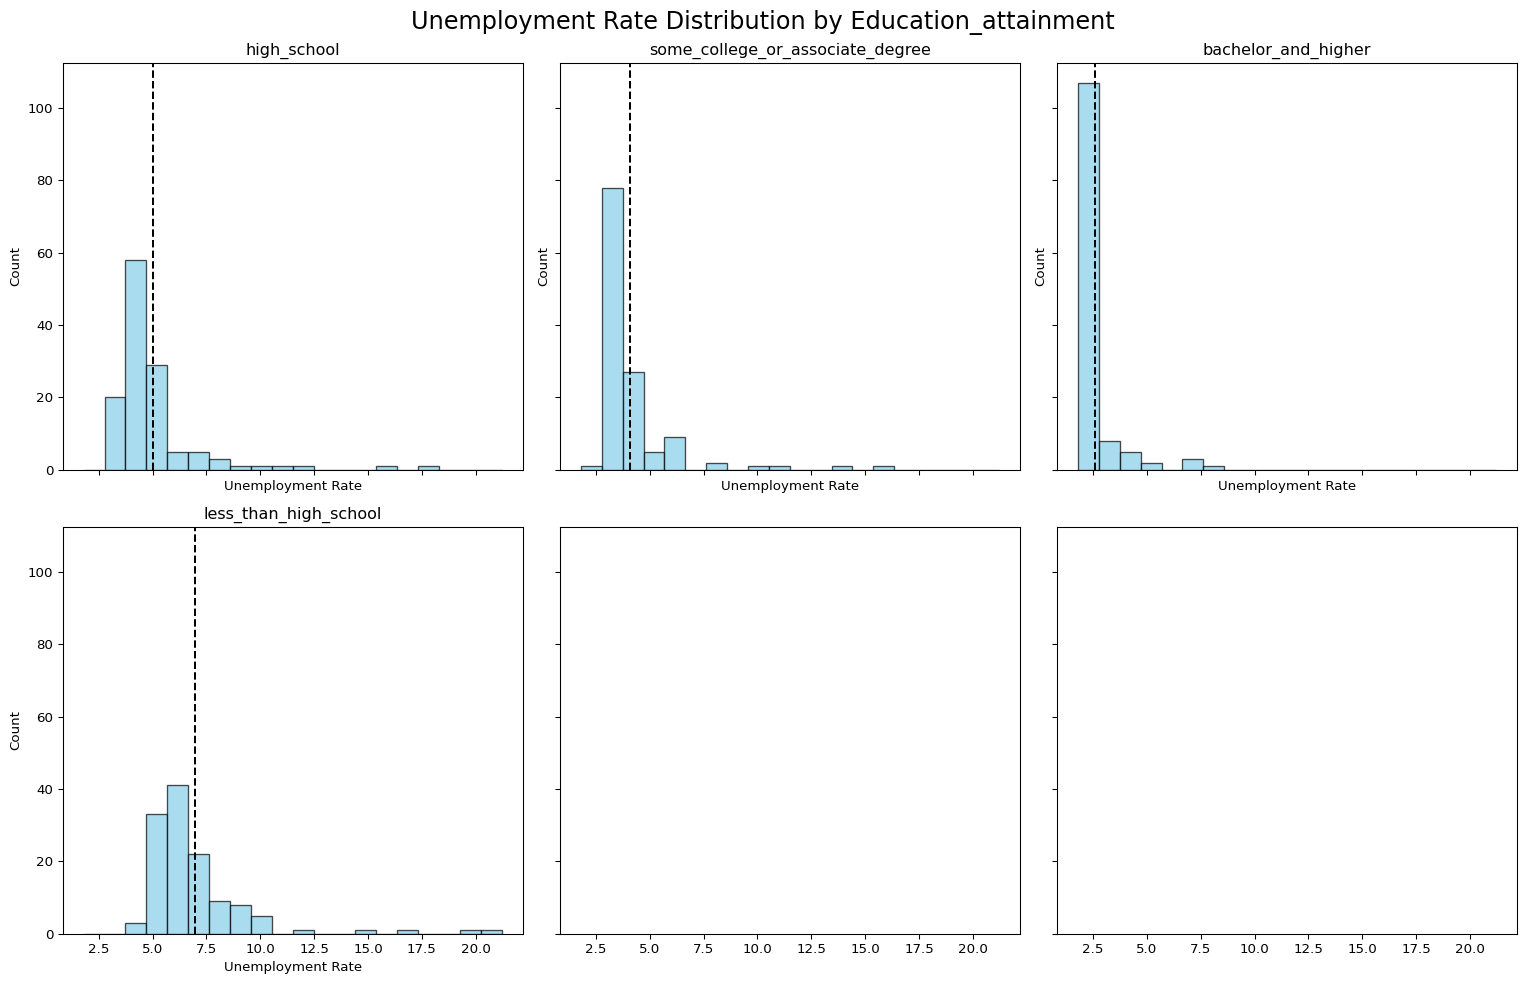

In [7]:
#| label: fig-histogram-unemployment-rate-demographics
#| fig-cap: Unemployment Rate Distributions By Demographics (2015-2025 statistics)
#| fig-alt: Histogram plots of the unemployment rate distributins by Age, Sex, Race, Industry and Education Attainment using 2015-2025 BLS data

## 2. Plot the overall umemployment rate 
## Display this graph separately from the preious chuck in order to add the aritcle label
df_plot = list(df_dic.values())[len(df_dic.keys())-1]
demographic_type = list(df_dic.keys())[len(df_dic.keys())-1]
print(f"Unemployment Rate Distribution Histograms By {demographic_type}")
plot_hist(df_plot, demographic_type)

BLS data from 2015–2025 indicate that the Black or African American population experienced the highest average unemployment rate (7.5%), primarily within the 5–10% range. Gender differences are minimal, with both averaging around 5%, though rates are slightly higher for men. Among industries, Leisure and Hospitality recorded the highest unemployment (10%) with a long-tail distribution, followed by Agriculture (5–11%) and moderate variability. Construction and Mining/Oil & Gas exhibit similar but marginally lower patterns. The 22–24 age group stands out with significantly elevated unemployment—averaging 7% and predominantly above 5%—while other age groups display lower and more uniform rates. Financial Activities show the lowest and most stable unemployment, consistently under 5%. Individuals without a high school diploma face high and variable unemployment, averaging 7% with a long-tail skew. These patterns suggest that young adults (22–24), Black or African Americans without college degrees, and those employed in Leisure, Construction, or Mining sectors are disproportionately affected by higher unemployment. (@fig-histogram-unemployment-rate-demographics).

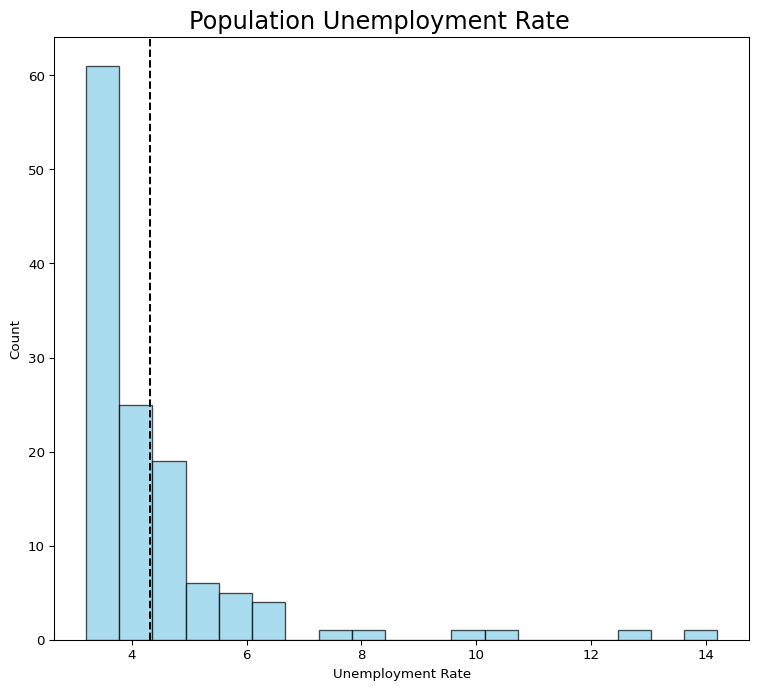

In [8]:
#| label: fig-histogram-unemployment-rate
#| fig-cap: Overall Population Unemployment Rate Distributions (2015-2025 statistics)
#| fig-alt: Histogram plot of the overall population unemployment rate distributions using 2015-2025 BLS data
min_rate = df_overall_long['Unemployment_rate'].min()
max_rate = df_overall_long['Unemployment_rate'].max()
num_bins = 20
bins = np.linspace(min_rate, max_rate, num_bins)
fig, ax = plt.subplots(figsize = (8, 7))
ax.hist(df_overall_long['Unemployment_rate'], bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
ax.axvline(np.mean(df_overall_long['Unemployment_rate']), color="black", linestyle="--")
ax.set_xlabel("Unemployment Rate", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
plt.tight_layout()
plt.suptitle("Population Unemployment Rate", y =1.02, fontsize=18)
plt.show()

According to BLS data from 2015–2025, the overall population unemployment rate averaged slightly above 4%, with the majority of observations concentrated between 2% and 5% and exhibiting relatively low variability (@fig-histogram-unemployment-rate).

### Unemployment Rates of Differenet Industries

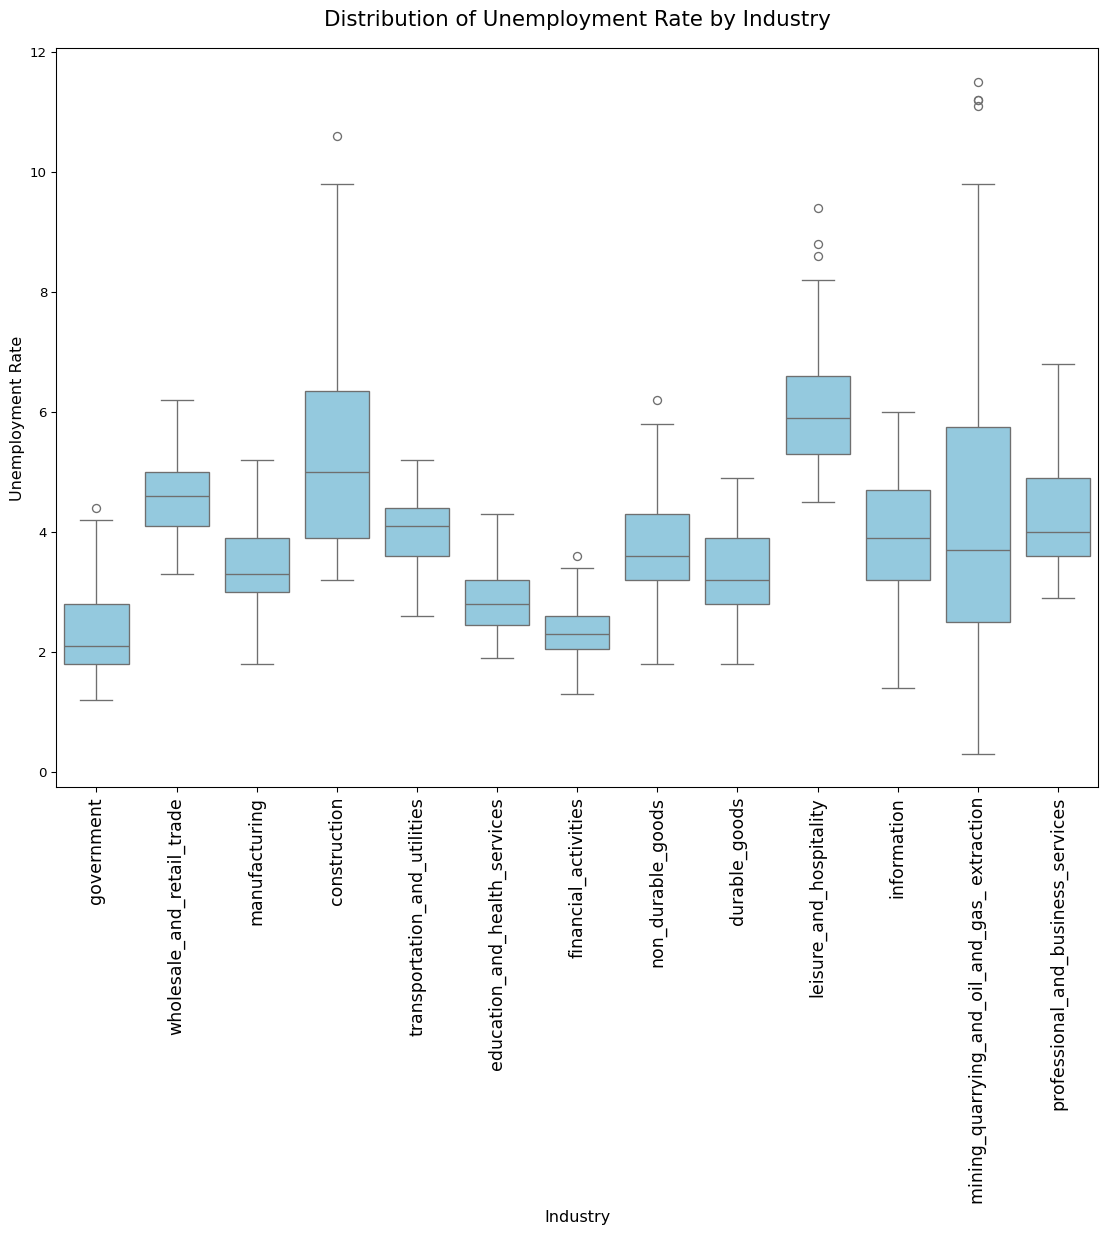

In [9]:
#| label: fig-boxplot-unemployment-rate-industry
#| fig-cap: Unemployment Rate Distributions By Industries (2015-2025 statistics)
#| fig-alt: Boxplot of the industry unemployment rates distributions using 2015-2025 BLS data

# Boxplot for unemployment rate by industry
import seaborn as sns
df_industry = df_dic['Industry']
df_industry = df_industry[~df_industry['Year'].isin([2020,2021])]
fig, ax = plt.subplots(figsize = (14,10))
sns.boxplot(df_industry, x="Industry", y="Unemployment_rate", color='skyblue', ax=ax)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Industry', fontsize=12)
ax.set_ylabel('Unemployment Rate', fontsize=12)
ax.set_title('Distribution of Unemployment Rate by Industry', y = 1.02, fontsize=16)
ax.tick_params(axis='x', labelsize=13, rotation=90)

The boxplot illustrates notable variation in unemployment rates across industries. "Agricultural, mining/oil/gas extraction" and "Construction" industries exhibit the highest variation and upper extremes, indicating greater instability in employment. Due to the volatility and unpredictivity as a result of seasonlity, these two categories are going to be excluded from our analysis. In contrast, "Government", "Financial services", and "Education/health services" show consistently low and stable unemployment rates, with narrower interquartile ranges and fewer outliers. These patterns suggest structural differences in labor market vulnerability across sectors. (@fig-boxplot-unemployment-rate-industry).


## PGM
We posit that unemployment vulnerability is driven by structural inequalities within the labor market, particularly those rooted in demographic and industrial dimensions. Demographic disparities are represented by variables such as race, age, and educational attainment and industry; sex is excluded from the analysis due to prior findings indicating minimal impact on unemployment rates. Establishing a baseline unemployment level is a necessary step before assessing the marginal effects of these demographic and industrial factors.

### Baseline unemployment rate distribution 
Figure 3 illustrates that the population unemployment rate is right-skewed, suggesting that the Log-Normal distribution is an appropriate model. We are going to estimate the parameters of a Log-Normal distribution from the population distribution data using MLE. ($\sigma$, $\text{loc}$, and $\text{scale}$).


Fitted Log-Norm Distribution Parameters:
  Shape parameter 'alpha'): 9.92
  Location parameter (loc): 3.20
  Scale parameter (scale): 0.03


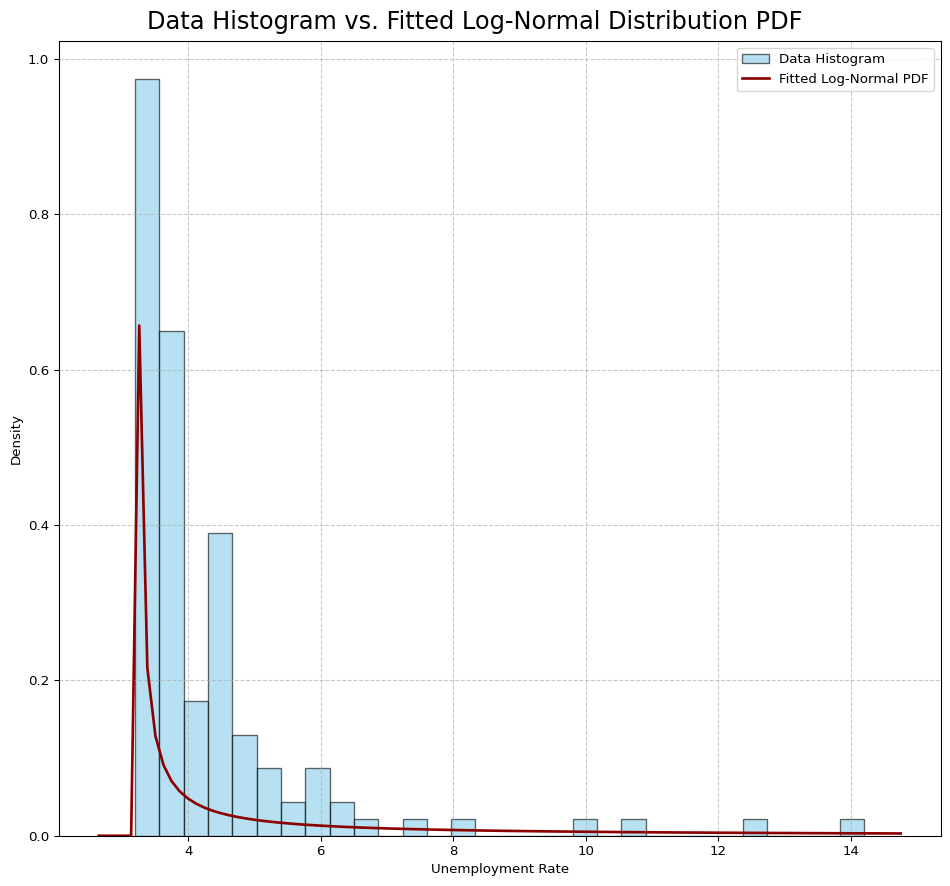

In [10]:
#| label: fig-histogram-lognorm
#| fig-cap: Unmployment Rate Histogram vs. Fitted Log-Norm PDF
#| fig-alt: Plot the histogram of unemployment rate data and overlay the Probability Density Function (PDF) of the fitted log-norm distribution.

# Fit log-norm distribution using population unemployment rate data
from scipy.stats import lognorm, kstest, skew 

## Get the unemployment_rate data that is not NA, convert to array
data_to_fit = df_overall_long[~np.isnan(np.array(df_overall_long['Unemployment_rate']))]['Unemployment_rate']

sigma_fit, loc_fit, scale_fit = lognorm.fit(data_to_fit) # Fit log-normal distribution

# Print the estimated parameters
print(f"\nFitted Log-Norm Distribution Parameters:")
print(f"  Shape parameter 'alpha'): {sigma_fit:.2f}")
print(f"  Location parameter (loc): {loc_fit:.2f}")
print(f"  Scale parameter (scale): {scale_fit:.2f}")

# Visualize the fit
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 9))
## Histogram of the unemployment data
ax.hist(data_to_fit, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Data Histogram')
## Fitted log-norm pdf
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = lognorm.pdf(x, sigma_fit, loc=loc_fit, scale=scale_fit)
ax.plot(x, p, 'darkred', lw=2, label='Fitted Log-Normal PDF')
ax.set_xlabel('Unemployment Rate', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.suptitle("Data Histogram vs. Fitted Log-Normal Distribution PDF", y=1.02, fontsize=18)
plt.show()

By overlaying the smooth PDF curve on top of original data's histogram, we can visualize that the Log-Normal distribution matches the distribution of the actual data. The peak of the PDF align with the peak of the histogram. The spread of the PDF roughly match the spread of the data, including the tail (@fig-histogram-lognorm).
Now we need to use Kolmogorov-Smirnov Test to test Goodness-of-fit with the original data and estimated parameters, then examine the p value. 

In [11]:
# KS goodness of fit test
d_statistic, p_value = kstest(data_to_fit, lambda x: lognorm.cdf(x, sigma_fit, loc=loc_fit, scale=scale_fit)) 
print(f"\nKolmogorov-Smirnov Test Results:")
print(f"  D-statistic: {d_statistic:.4f}")
print(f"  P-value: {p_value:.4f}")


Kolmogorov-Smirnov Test Results:
  D-statistic: 0.4592
  P-value: 0.0000


With $p$-value < 0.05, we can't reject the hypothesis that the distribution does not come from the Log-Normal distribution, suggesting Log-Normal is not a good fit for the data. Next, explore other right-skewed distributions - Gamma distribution or the Weibull distribution.


Fitted Gamma Distribution Parameters:
  Shape parameter 'alpha': 0.45
  Location parameter 'loc': 3.20
  Scale parameter 'scale'): 1.36


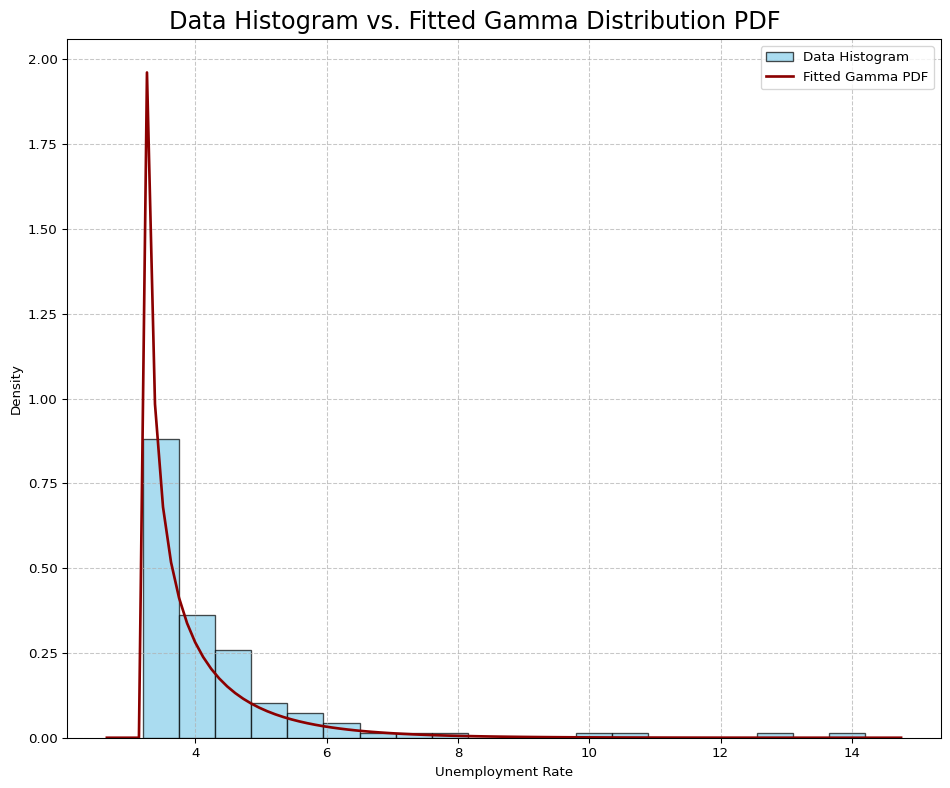

In [12]:
#| label: fig-histogram-gamma
#| fig-cap: Unmployment Rate Histogram vs. Fitted Gamma PDF
#| fig-alt: Plot the histogram of unemployment rate data and overlay the Probability Density Function (PDF) of the fitted Gamma distribution.

# Fit gamma distribution using MLE
from scipy.stats import gamma, skew, kstest
alpha_fit, loc_fit, scale_fit = gamma.fit(data_to_fit) # fit gamma distribution

# Print the estimated parameters
print(f"\nFitted Gamma Distribution Parameters:")
print(f"  Shape parameter 'alpha': {alpha_fit:.2f}")
print(f"  Location parameter 'loc': {loc_fit:.2f}")
print(f"  Scale parameter 'scale'): {scale_fit:.2f}")

# Visualize the fit
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
## Histogram of the unemployment data
ax.hist(data_to_fit, bins = 20, density=True, color='skyblue', alpha= 0.7, edgecolor='black', label = 'Data Histogram')
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)

## Plot fitted gamma pdf
p = gamma.pdf(x, alpha_fit, loc=loc_fit, scale=scale_fit)
ax.plot(x, p, 'darkred', lw=2, label='Fitted Gamma PDF')
ax.set_xlabel('Unemployment Rate', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.suptitle("Data Histogram vs. Fitted Gamma Distribution PDF", y=1.02, fontsize=18)
plt.show()

Although visually the Gamma distribution matches the shape and spread of the actual data. (@fig-histogram-gamma), we need to
use KS Test to test Goodness-of-fit by examining the p value. 

In [13]:
# Fit the gamma 
d_statistic, p_value = kstest(data_to_fit, lambda x: gamma.cdf(x, alpha_fit, loc=loc_fit, scale=scale_fit))
print(f"\nKolmogorov-Smirnov Test Results:")
print(f"  D-statistic: {d_statistic:.4f}")
print(f"  P-value: {p_value:.4f}")


Kolmogorov-Smirnov Test Results:
  D-statistic: 0.2699
  P-value: 0.0000


Again, with $p$-value < 0.05, we can not confidently say that the data comes from the Gamma distribution. Next, explore Weibull distribution.

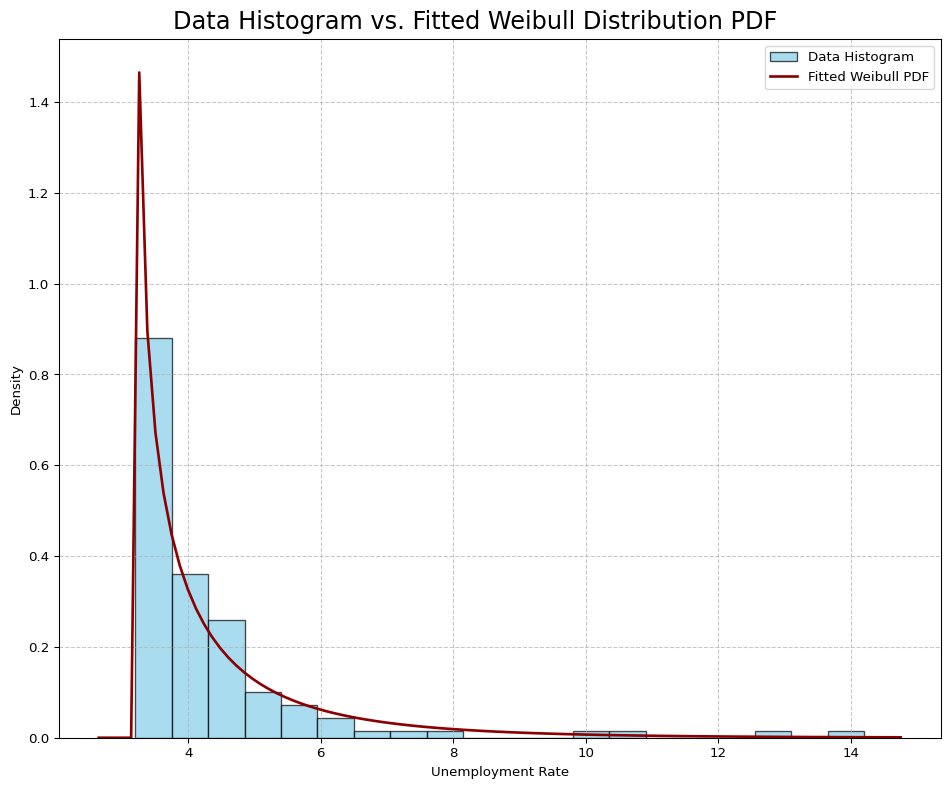

In [14]:
#| label: fig-histogram-weibull
#| fig-cap: Unmployment Rate Histogram vs. Fitted Weibull PDF
#| fig-alt: Plot the histogram of unemployment rate data and overlay the Probability Density Function (PDF) of the fitted Weibull distribution.

# Fit Weibull distribution using MLE
from scipy.stats import weibull_min, skew, kstest
from scipy.special import gamma as gamma_func # For Weibull mean calculation
c_fit, loc_fit, scale_fit = weibull_min.fit(data_to_fit) # fit weibull distribution

# Print the estimated parameters
# print(f"\nFitted Weibull Distribution Parameters:")
# print(f"  Shape parameter 'c' (k): {c_fit:.4f}")
# print(f"  Location parameter (loc): {loc_fit:.4f}")
# print(f"  Scale parameter (scale, lambda): {scale_fit:.4f}")

# Visualize the fit
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
## Histogram of the unemployment data
ax.hist(data_to_fit, bins = 20, density=True, color='skyblue', alpha= 0.7, edgecolor='black', label = 'Data Histogram')
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)

## Plot fitted gamma pdf
p = weibull_min.pdf(x, c_fit, loc=loc_fit, scale=scale_fit)
ax.plot(x, p, 'darkred', lw=2, label='Fitted Weibull PDF')
ax.set_xlabel('Unemployment Rate', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.suptitle("Data Histogram vs. Fitted Weibull Distribution PDF", y=1.02, fontsize=18)
plt.show()

In [15]:
# Fit the Weibull
d_statistic, p_value = kstest(data_to_fit, lambda x: weibull_min.cdf(x, c_fit, loc=loc_fit, scale=scale_fit))
# Calculate inferred mean
fitted_mean = loc_fit + scale_fit * gamma_func(1 + 1/c_fit)
# print(f"\nKolmogorov-Smirnov Test Results:")
# print(f"  D-statistic: {d_statistic:.4f}")
# print(f"  P-value: {p_value:.4f}")

In [16]:
#| label: tbl-weibull-params
#| tbl-cap: Weibull Distribution and Fitness Statistics

# Print out the Weibull stats
weibull_stats = {
  "Parameters": [
    "Shape (c)",
    "Location (loc)" ,
    "Scale",
    "D_statistics",
    "P-value",
    "Fitted Mean"
  ],
  "Values": [
     round(c_fit, 4),
     round(loc_fit, 4),
     round(scale_fit, 4),
     round(d_statistic, 4),
     round(p_value, 4),
     round(fitted_mean, 2)
  ]
}
weibull_stats_table = pd.DataFrame(weibull_stats)
display(weibull_stats_table.style.hide(axis="index"))

Parameters,Values
Shape (c),0.709300
Location (loc),3.200000
Scale,0.920400
D_statistics,0.104700
P-value,0.117300
Fitted Mean,4.350000


The overlayed smooth PDF curve on top of original data's histogram @fig-histogram-weibull suggests that the Weibull distribution matches the distribution of the actual data. The results of the Weibull distribution, summarized in Table @tbl-weibull-params, including the shape, location, and scale parameters, along with the D-statistic, P-value, and fitted mean also proves Weibull distribution is a good fit, supported by a KS test p-value of 0.1173 (greater than 0.05). The estimated parameters (c=0.7093, loc=3.2000, scale=0.9204) align well with the spread of the data. Shape (c<1): Confirms the strong right-skewness of the data. Location (loc=3.2000): Indicates the distribution starts around 3.20, matching data's lower bound. Inferred Mean: The calculated mean of approximately 4.35 from these parameters is close but slightly higher than the data's actual mean of around 4, showing a good capture of central tendency.

### Define the prior means for overall population
```python
### population unemployment mean probability from the fitted Weibull distribution
weibull_fitted_mean_prob = 0.0435
# Convert the fitted mean probability to its log-odds equivalent in order to model binary outcome with logistic regression
population_mean_log_odds = np.log(weibull_fitted_mean_prob / (1 - weibull_fitted_mean_prob))
```

In [17]:
### population unemployment mean probability from the fitted Weibull distribution
weibull_fitted_mean_prob = 0.0435
# Convert the fitted mean probability to its log-odds equivalent in order to model binary outcome with logistic regression
population_mean_log_odds = np.log(weibull_fitted_mean_prob / (1 - weibull_fitted_mean_prob))

### Define the prior means by races
```python
# Function to find the means of different demographics
def mean_prob_demographic(df_name, demographic_type, demographic_description):
    demographic_mean_prob = df_dic[df_name].loc[df_dic[df_name][demographic_type]==demographic_description]['Unemployment_rate'].mean()/100
    demographic_mean_log_odds = np.log(demographic_mean_prob / (1 - demographic_mean_prob))
    # beta_effect is the difference between the demographic group mean log-odds and the population mean log-odds
    beta_effect = demographic_mean_log_odds - population_mean_log_odds
    return beta_effect

# Create a grid of demographic information to return the means
demographic_grid = pd.DataFrame({
    "df_name":[
        'Race',
        'Race',
        'Race'
    ],
    "demographic_type":[
        "Race", 
        "Race",
        "Race"
    ],
    "demographic_description":[
        'black_and_african',
        'white',
        'asian'
    ]
})
# Return the means
demographic_grid['beta_effect']= np.float64(0)
for row in range(0,len(demographic_grid)):
    # Mean of demographic groups
    beta_effect = mean_prob_demographic(demographic_grid['df_name'][row], demographic_grid['demographic_type'][row], demographic_grid['demographic_description'][row])
    demographic_grid['beta_effect'][row] = beta_effect

```

In [18]:
# Function to find the means of different demographics
def mean_prob_demographic(df_name, demographic_type, demographic_description):
    demographic_mean_prob = df_dic[df_name].loc[df_dic[df_name][demographic_type]==demographic_description]['Unemployment_rate'].mean()/100
    demographic_mean_log_odds = np.log(demographic_mean_prob / (1 - demographic_mean_prob))
    # beta_effect is the difference between the demographic group mean log-odds and the population mean log-odds
    beta_effect = demographic_mean_log_odds - population_mean_log_odds
    return beta_effect

# Create a grid of demographic information to return the means
demographic_grid = pd.DataFrame({
    "df_name":[
        'Race',
        'Race',
        'Race'
    ],
    "demographic_type":[
        "Race", 
        "Race",
        "Race"
    ],
    "demographic_description":[
        'black_and_african',
        'white',
        'asian'
    ]
})
# Return the beta_effect of different demographics
demographic_grid['beta_effect']= np.float64(0)
for row in range(0,len(demographic_grid)):
    # Mean of demographic groups
    beta_effect = mean_prob_demographic(demographic_grid['df_name'][row], demographic_grid['demographic_type'][row], demographic_grid['demographic_description'][row])
    demographic_grid['beta_effect'][row] = beta_effect

### Define the unemployment-race PyMC
This section sets up the Bayesian model to estimate the additive race effect relative to the fixed baseline.
```python

# Create the pymc model
import pymc as pm
import arviz as az

with pm.Model() as unemployment_race_model:
    # Prior of population mean log odds
    mu_population_log_odds = pm.Normal('mu_population_log_odds', mu=population_mean_log_odds, sigma=0.5)
    
    # Additive race effect parameter on population mean
    beta_black = pm.Normal('beta_black', mu=demographic_grid[demographic_grid['demographic_description']=='black_and_african']['beta_effect'], sigma=0.3) # Can be positive or negative

    beta_asian = pm.Normal('beta_asian', mu=demographic_grid[demographic_grid['demographic_description']=='asian']['beta_effect'], sigma=0.3) 

    beta_white = pm.Normal('beta_white', mu=demographic_grid[demographic_grid['demographic_description']=='white']['beta_effect'], sigma=0.3) 
    
    # noise
    sigma = pm.HalfNormal('sigma', sigma=0.2)

    # log-odds and probabilities for each racial group
    mu_white_log_odds = pm.Deterministic('mu_white_log_odds', mu_population_log_odds + beta_white)
    mu_black_log_odds = pm.Deterministic('mu_black_log_odds', mu_population_log_odds + beta_black)
    mu_asian_log_odds = pm.Deterministic('mu_asian_log_odds', mu_population_log_odds + beta_asian)

    p_population = pm.Deterministic('p_population', pm.math.invlogit(mu_population_log_odds))
    p_white = pm.Deterministic('p_white', pm.math.invlogit(mu_white_log_odds))
    p_black = pm.Deterministic('p_black', pm.math.invlogit(mu_black_log_odds))
    p_asian = pm.Deterministic('p_asian', pm.math.invlogit(mu_asian_log_odds))

    # Likelihoods for observed data: use parameters like derived above to make predictions about the "true" probabilities of unemployment.

    # predict population mean
    population_rates_df = df_overall_long[~np.isnan(df_overall_long['Unemployment_rate'])]
    population_rates_df['rate_logit'] = np.log(population_rates_df['Unemployment_rate']*0.01/(1-population_rates_df['Unemployment_rate']*0.01))
    population_rates_obs = pm.Normal(
        'population_rates_obs',
        mu=mu_population_log_odds, 
        sigma=sigma,
        observed=population_rates_df['rate_logit'].values
    )

    # predict black mean
    black_rates_df = df_dic['Race'][df_dic['Race']['Race']=='black_and_african']
    black_rates_df = black_rates_df[~np.isnan(black_rates_df['Unemployment_rate'])] 
    black_rates_df['rate_logit'] = np.log(black_rates_df['Unemployment_rate']*0.01/(1-black_rates_df['Unemployment_rate']*0.01))
    black_rates_obs = pm.Normal(
        'black_rates_obs',
        mu=mu_black_log_odds, 
        sigma=sigma,
        observed=black_rates_df['rate_logit'].values
    )

    # predict asian mean
    asian_rates_df = df_dic['Race'][df_dic['Race']['Race']=='asian']
    asian_rates_df = asian_rates_df[~np.isnan(asian_rates_df['Unemployment_rate'])] 
    asian_rates_df['rate_logit'] = np.log(asian_rates_df['Unemployment_rate']*0.01/(1-asian_rates_df['Unemployment_rate']*0.01))
    asian_rates_obs = pm.Normal(
        'asian_rates_obs',
        mu=mu_asian_log_odds,
        sigma=sigma,
        observed=asian_rates_df['rate_logit'].values
    )

    # predict white mean
    white_rates_df = df_dic['Race'][df_dic['Race']['Race']=='white']
    white_rates_df = white_rates_df[~np.isnan(white_rates_df['Unemployment_rate'])] 
    white_rates_df['rate_logit'] = np.log(white_rates_df['Unemployment_rate']*0.01/(1-white_rates_df['Unemployment_rate']*0.01))
    white_rates_obs = pm.Normal(
        'white_rates_obs',
        mu=mu_white_log_odds,
        sigma=sigma,
        observed=white_rates_df['rate_logit'].values
    )
    
    # Assign the correct probability based on race
    p_individual_for_obs = pm.math.switch(
        df_survey_jun['is_black_african'].values,
        p_black, # if is_black, use black prob
        pm.math.switch(
            df_survey_jun['is_asian'].values, 
            p_asian, # if is_asian, use asian prob
            p_white # else, use white prob
        )
    )
    individual_status_obs = pm.Bernoulli(
        'individual_status_obs',
        p=p_individual_for_obs,
        observed=df_survey_jun['unemployment_status'].values
    )
```

In [19]:
import pymc as pm
import arviz as az

with pm.Model() as unemployment_race_model:
    # Prior of population mean log odds
    mu_population_log_odds = pm.Normal('mu_population_log_odds', mu=population_mean_log_odds, sigma=0.5)
    
    # Additive race effect parameter on population mean
    beta_black = pm.Normal('beta_black', mu=demographic_grid[demographic_grid['demographic_description']=='black_and_african']['beta_effect'], sigma=0.3) # Can be positive or negative

    beta_asian = pm.Normal('beta_asian', mu=demographic_grid[demographic_grid['demographic_description']=='asian']['beta_effect'], sigma=0.3) 

    beta_white = pm.Normal('beta_white', mu=demographic_grid[demographic_grid['demographic_description']=='white']['beta_effect'], sigma=0.3) 
    
    # noise
    sigma = pm.HalfNormal('sigma', sigma=0.2)

    # log-odds and probabilities for each racial group
    mu_white_log_odds = pm.Deterministic('mu_white_log_odds', mu_population_log_odds + beta_white)
    mu_black_log_odds = pm.Deterministic('mu_black_log_odds', mu_population_log_odds + beta_black)
    mu_asian_log_odds = pm.Deterministic('mu_asian_log_odds', mu_population_log_odds + beta_asian)

    p_population = pm.Deterministic('p_population', pm.math.invlogit(mu_population_log_odds))
    p_white = pm.Deterministic('p_white', pm.math.invlogit(mu_white_log_odds))
    p_black = pm.Deterministic('p_black', pm.math.invlogit(mu_black_log_odds))
    p_asian = pm.Deterministic('p_asian', pm.math.invlogit(mu_asian_log_odds))

    # Likelihoods for observed data: use parameters like derived above to make predictions about the "true" probabilities of unemployment.

    # predict population mean
    population_rates_df = df_overall_long[~np.isnan(df_overall_long['Unemployment_rate'])]
    population_rates_df['rate_logit'] = np.log(population_rates_df['Unemployment_rate']*0.01/(1-population_rates_df['Unemployment_rate']*0.01))
    population_rates_obs = pm.Normal(
        'population_rates_obs',
        mu=mu_population_log_odds, 
        sigma=sigma,
        observed=population_rates_df['rate_logit'].values
    )

    # predict black mean
    black_rates_df = df_dic['Race'][df_dic['Race']['Race']=='black_and_african']
    black_rates_df = black_rates_df[~np.isnan(black_rates_df['Unemployment_rate'])] 
    black_rates_df['rate_logit'] = np.log(black_rates_df['Unemployment_rate']*0.01/(1-black_rates_df['Unemployment_rate']*0.01))
    black_rates_obs = pm.Normal(
        'black_rates_obs',
        mu=mu_black_log_odds, 
        sigma=sigma,
        observed=black_rates_df['rate_logit'].values
    )

    # predict asian mean
    asian_rates_df = df_dic['Race'][df_dic['Race']['Race']=='asian']
    asian_rates_df = asian_rates_df[~np.isnan(asian_rates_df['Unemployment_rate'])] 
    asian_rates_df['rate_logit'] = np.log(asian_rates_df['Unemployment_rate']*0.01/(1-asian_rates_df['Unemployment_rate']*0.01))
    asian_rates_obs = pm.Normal(
        'asian_rates_obs',
        mu=mu_asian_log_odds,
        sigma=sigma,
        observed=asian_rates_df['rate_logit'].values
    )

    # predict white mean
    white_rates_df = df_dic['Race'][df_dic['Race']['Race']=='white']
    white_rates_df = white_rates_df[~np.isnan(white_rates_df['Unemployment_rate'])] 
    white_rates_df['rate_logit'] = np.log(white_rates_df['Unemployment_rate']*0.01/(1-white_rates_df['Unemployment_rate']*0.01))
    white_rates_obs = pm.Normal(
        'white_rates_obs',
        mu=mu_white_log_odds,
        sigma=sigma,
        observed=white_rates_df['rate_logit'].values
    )
    
    # Assign the correct probability based on race
    p_individual_for_obs = pm.math.switch(
        df_survey_jun['is_black_african'].values,
        p_black, # if is_black, use black prob
        pm.math.switch(
            df_survey_jun['is_asian'].values, 
            p_asian, # if is_asian, use asian prob
            p_white # else, use white prob
        )
    )
    individual_status_obs = pm.Bernoulli(
        'individual_status_obs',
        p=p_individual_for_obs,
        observed=df_survey_jun['unemployment_status'].values
    )

### Graph the unemployment-race PGM
```python
pm.model_to_graphviz(unemployment_race_model)
```

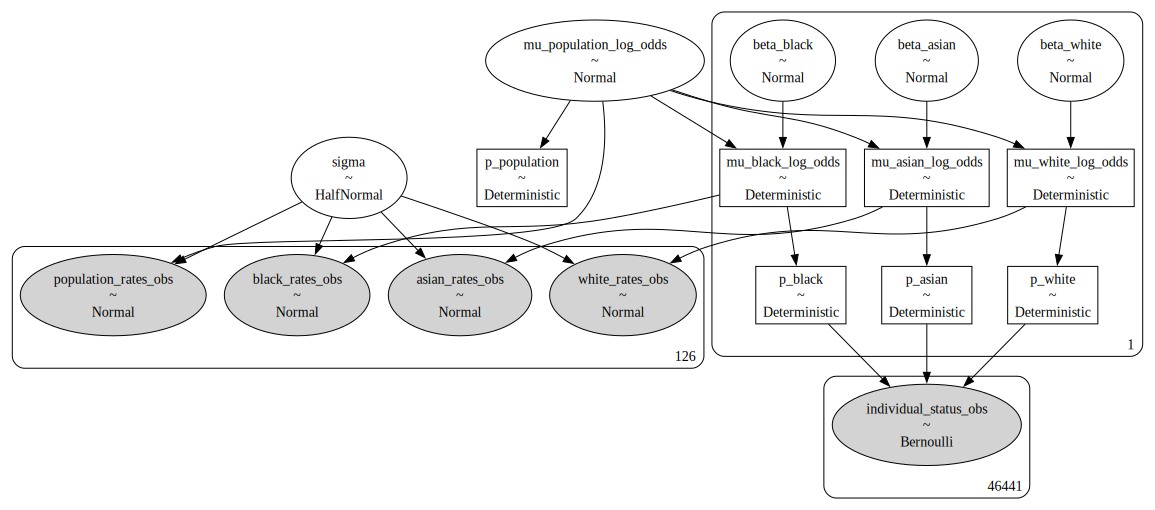

In [20]:
pm.model_to_graphviz(unemployment_race_model)

### Fit the unemployment-race Model - Perform MCMC Sampling
```python
print("Starting MCMC sampling...")
with unemployment_race_model:
    indiv_trace = pm.sample(random_seed=5650)
```

In [21]:
print("Starting MCMC sampling...")
with unemployment_race_model:
    indiv_trace = pm.sample(random_seed=5650)

Starting MCMC sampling...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_population_log_odds, beta_black, beta_asian, beta_white, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


### Analyze unemployment-race Results and Visualize
```python
# Analyze Results and Visualize
print("\n--- Model Summary (Simplified Model - Multiple Races) ---")
display(pd.DataFrame(az.summary(indiv_trace, var_names=['mu_population_log_odds', 'beta_black', 'beta_asian', 'beta_white', 'sigma'])))
# Trace plot
fig_trace = az.plot_trace(indiv_trace)
plt.suptitle('Trace plot', fontsize=16)
plt.subplots_adjust(hspace=0.5) 

# Convert to DataFrame
indiv_post_df = indiv_trace.posterior.to_dataframe().reset_index()
# Extract only the first chain
indiv_post_df = indiv_post_df[indiv_post_df['chain'] == 0]
# Melt
indiv_post_df = indiv_post_df[['draw','beta_black', 'beta_asian', 'beta_white']].melt(id_vars=['draw'])

# Density Plot
import seaborn as sns
import patchworklib as pw
ax = pw.Brick(figsize=(4, 2.5));
sns.kdeplot(
    x="value", hue="variable", data=indiv_post_df, ax=ax,
    fill=True, bw_adjust=2,
);
ax.set_xlabel("Log-Odds Deviation from Overall Mean")
ax.set_ylabel("Density")
ax.set_title("Posterior Distribution of Race Effect Deviations")

```


--- Model Summary (Simplified Model - Multiple Races) ---


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_population_log_odds,-3.146,0.028,-3.199,-3.093,0.001,0.000,1539.0,1941.0,1.0
beta_black[0],0.565,0.038,0.497,0.640,0.001,0.001,1845.0,2677.0,1.0
beta_asian[0],-0.149,0.039,-0.218,-0.075,0.001,0.001,1859.0,2245.0,1.0
beta_white[0],-0.128,0.034,-0.191,-0.065,0.001,0.000,1772.0,2332.0,1.0
sigma,0.320,0.010,0.301,0.340,0.000,0.000,3604.0,2570.0,1.0


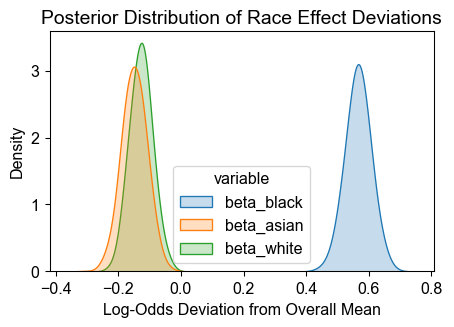

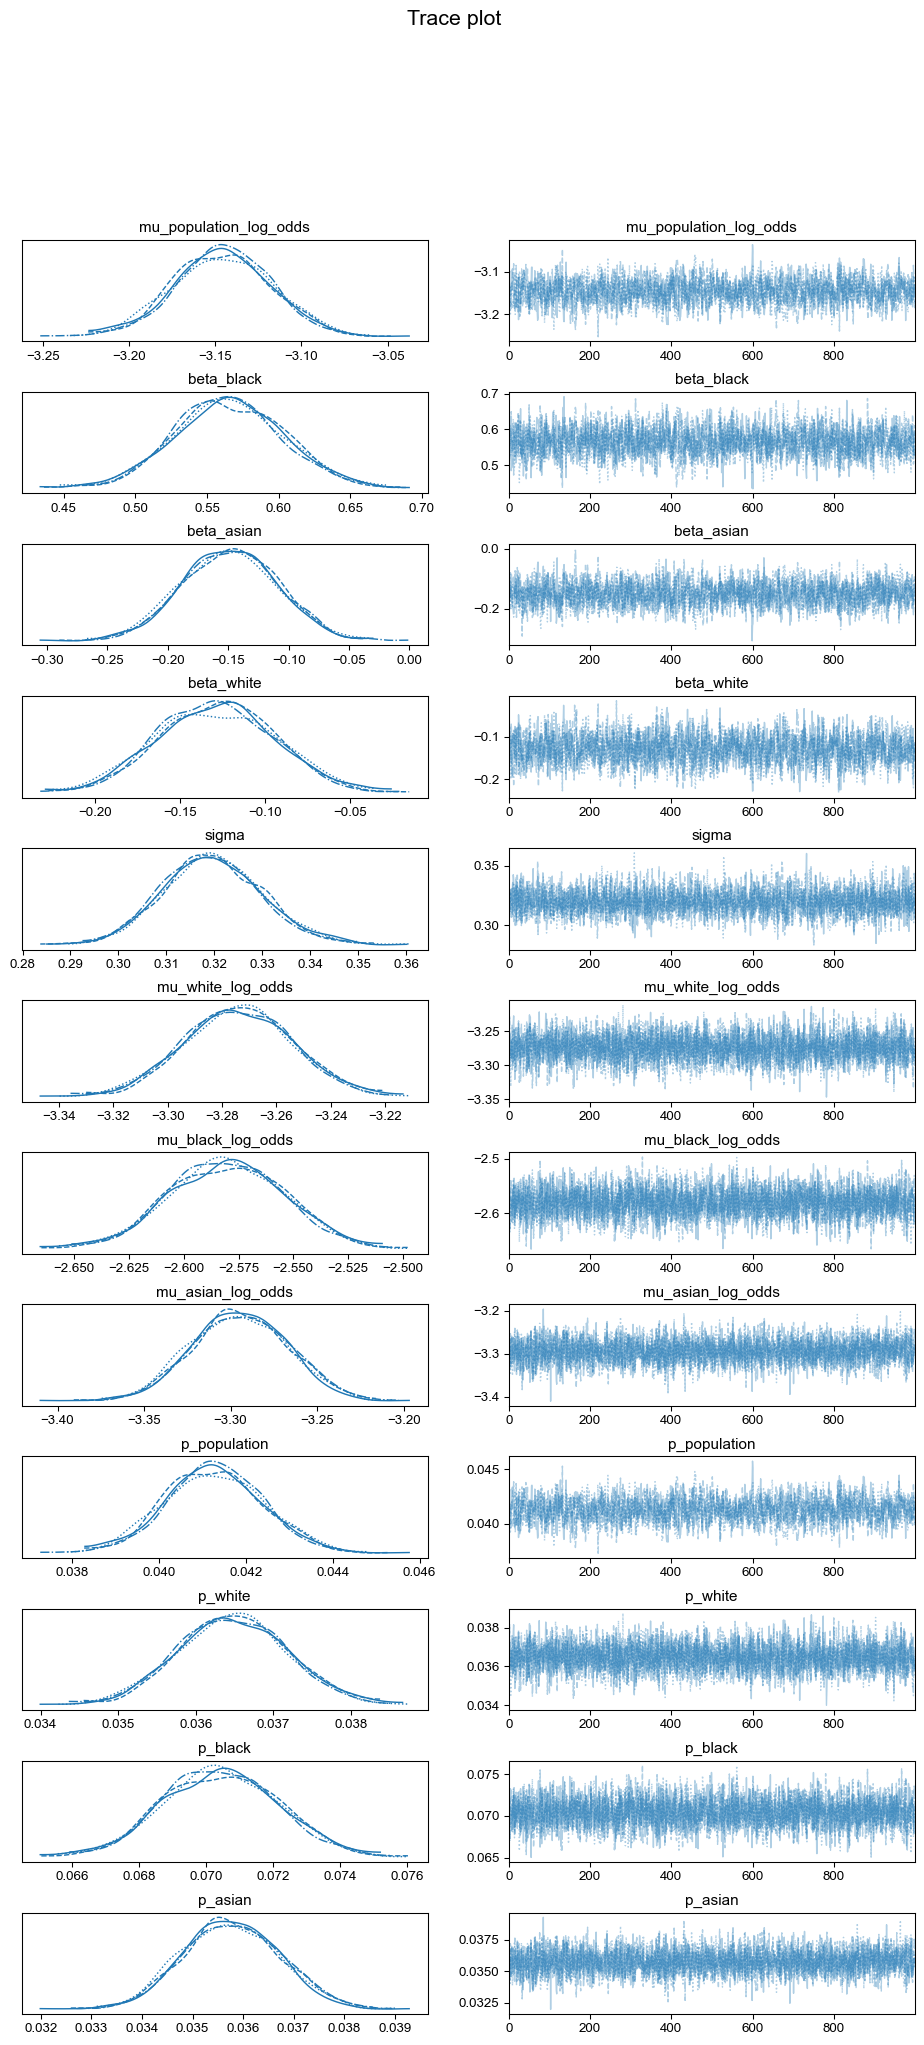

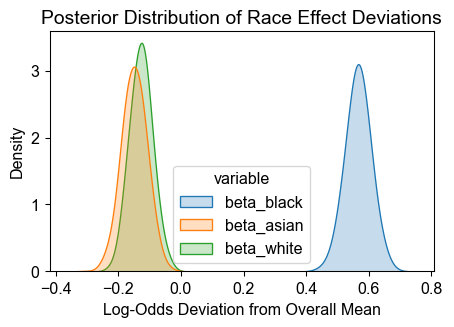

In [22]:
# Analyze Results and Visualize
print("\n--- Model Summary (Simplified Model - Multiple Races) ---")
display(pd.DataFrame(az.summary(indiv_trace, var_names=['mu_population_log_odds', 'beta_black', 'beta_asian', 'beta_white', 'sigma'])))

# Trace plot
fig_trace = az.plot_trace(indiv_trace)
plt.suptitle('Trace plot', fontsize=16)
plt.subplots_adjust(hspace=0.5) 

# Convert to DataFrame
indiv_post_df = indiv_trace.posterior.to_dataframe().reset_index()
# Extract only the first chain
indiv_post_df = indiv_post_df[indiv_post_df['chain'] == 0]
# Melt
indiv_post_df = indiv_post_df[['draw','beta_black', 'beta_asian', 'beta_white']].melt(id_vars=['draw'])

# Density plot
import seaborn as sns
import patchworklib as pw
ax = pw.Brick(figsize=(4, 2.5));
sns.kdeplot(
    x="value", hue="variable", data=indiv_post_df, ax=ax,
    fill=True, bw_adjust=2,
);
ax.set_xlabel("Log-Odds Deviation from Overall Mean")
ax.set_ylabel("Density")
ax.set_title("Posterior Distribution of Race Effect Deviations")
ax.savefig()

The posterior distributions of racial group mean log-odds for unemployment reveal clear deviations, with the Black population exhibiting a higher rate compared to both the White and Asian populations.

### PGM for unemployment-industry
```python
## 1. Exclude some industries and persons "not in labor force" and industries that don't have historical unemployment stats
survey_df_industry = survey_df[~survey_df['industry_name'].isin(['Construction',
                              'Mining',
                              'Other services',
                              'Agriculture, forestry, fishing, and hunting',
                              'Armed Forces'])]
survey_df_industry = survey_df_industry[survey_df_industry['employment_status_description']!="not in labor force"]
## Factorize the industry_name column to get numerical indices and names
industry_idx, industry_names = survey_df_industry['industry_name'].factorize()
survey_df_industry['industry_idx'] = industry_idx
## Map EmploymentStatus to numerical (0 for Employed, 1 for Unemployed)
survey_df_industry['unemployment_status'] = survey_df_industry['employment_status_description'].map({'employed': 0, 'unemployed': 1})

## 2. Get the prior means and sds of unemployment rates by industries from the historical monthly statistics (exlcuding 2020-2021)
df_industry_monthly_ur = df_industry[~df_industry['Industry'].isin(['construction',
                              'mining_quarrying_and_oil_and_gas_ extraction',
                              'other_services',
                              'agricultural',
                              'self_employed',
                              'non_durable_goods',
                              'durable_goods'])]

ur_by_industry = pd.DataFrame(df_industry_monthly_ur.groupby('Industry', as_index=False).agg(
    mean_ur = ('Unemployment_rate','mean'),
    sd_ur = ('Unemployment_rate', 'std')
))
 # modify the industry name column to align with industry_names
ur_by_industry['Industry']=['Educational and health services',
                            'Financial activities',
                            'Public administration',
                            'Information',
                            'Leisure and hospitality',
                            'Manufacturing',
                            'Professional and business services',
                            'Transportation and utilities',
                            'Wholesale and retail trade']
# Logit transformation function
def logit(p):
    return np.log(p / (1 - p))
ur_by_industry['mean_ur_logit'] = logit(ur_by_industry['mean_ur']/100)
ur_by_industry['sd_ur_logit'] = logit(ur_by_industry['sd_ur']/100)

## 3. Define the Adaptive pooling PyMC model
# priors
ur_by_industry_copy = ur_by_industry.copy()
ur_by_industry_copy = ur_by_industry_copy.set_index('Industry')
prior_mu_alpha_vals = np.array([ur_by_industry_copy.loc[ind, 'mean_ur_logit'] for ind in industry_names])
prior_sigma_alpha_vals = np.array([ur_by_industry_copy.loc[ind, 'sd_ur_logit'] for ind in industry_names])
# Define the PGM model
coords = {"industry": industry_names}
with pm.Model(coords=coords) as adaptive_unemployment_industry_model:
    industry_idx_obs = pm.Data("industry_idx_obs", survey_df_industry['industry_idx'].values, dims="obs_id")
    # Global Priors 
    sigma = pm.Exponential("sigma", 1) # standard deviation for alpha_industry
    # Industry-Specific Parameters - observed industry means
    mu_alpha_industry = pm.Data("mu_alpha_industry", prior_mu_alpha_vals, dims="industry") # history industry means
    alpha_industry = pm.Normal("alpha_industry", 
                                mu=mu_alpha_industry, # historical industry means
                                sigma=sigma,
                                dims="industry")
    # Probability of unemployment of each industry determined by alpha_industry
    p_unemployment = pm.Deterministic("p_unemployment", pm.invlogit(alpha_industry[industry_idx_obs]))
    # Observed data - unemployment status
    unemployment_status_observed = pm.Bernoulli("unemployment_status", 
                                            p=p_unemployment, 
                                            observed=survey_df_industry['unemployment_status'].values,
                                            dims="obs_id")

## 4.Visualize the PGM
pm.model_to_graphviz(adaptive_unemployment_industry_model)  

## 5.MCMC sampling and prediction
with adaptive_unemployment_industry_model:
    ur_industry_trace = pm.sample(tune = 500, draws=500, random_seed=5650)
# Pring summary of the trace
trace_alpha_summary = az.summary(
    ur_industry_trace,
    var_names=['alpha_industry'],
    kind="stats", 
    round_to=2
)
display(trace_alpha_summary)
# post mean
ur_industry_post_mean = ur_industry_trace.posterior.mean(dim=("chain", "draw"))
ur_industry_post_mean_iter = ur_industry_post_mean.sortby("alpha_industry")
ur_industry_post_mean_iter['alpha_prob'] = 1 / (1 + np.exp(-ur_industry_post_mean_iter['alpha_industry']))
ur_industry_post_mean.to_dataframe()
ur_industry_post_hdi = az.hdi(ur_industry_trace)
ur_industry_post_hdi_iter = ur_industry_post_hdi.sortby(ur_industry_post_mean_iter.alpha_industry)
ur_industry_post_hdi_iter['alpha_prob']=1 / (1 + np.exp(-ur_industry_post_hdi_iter['alpha_industry']))
ur_industry_post_hdi_iter.to_dataframe()
# Plot the posterior alpha_industry (mean of unemployment)
fig, ax = plt.subplots(figsize=(10, 8))
ur_industry_post_mean_iter.plot.scatter(x='industry', y="alpha_prob", ax=ax, alpha=0.8, s=80)
ax.vlines(
    np.arange(industry_names.size),
    ur_industry_post_hdi_iter.alpha_prob.sel(hdi="lower"),
    ur_industry_post_hdi_iter.alpha_prob.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
    linewidth=3
)
ax.grid(True, linestyle='--', alpha=0.6, color='lightgray')     
ax.tick_params(axis='x', labelsize=10, rotation=90)
ax.set_xlabel('Industry', fontsize = 12)
ax.set_ylabel('Posterior means', fontsize = 12)
ax.set_title("Estimated Industry-Specific Unemployment Rate (Adaptive Pooling)", y=1.02, fontsize=16)
plt.tight_layout() 

```

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [sigma, alpha_industry]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 120 seconds.


,mean,sd,hdi_3%,hdi_97%
alpha_industry[Leisure and hospitality],-2.81,0.02,-2.84,-2.77
alpha_industry[Educational and health services],-3.72,0.02,-3.75,-3.69
alpha_industry[Wholesale and retail trade],-3.12,0.02,-3.16,-3.09
alpha_industry[Manufacturing],-3.45,0.02,-3.49,-3.40
alpha_industry[Financial activities],-3.75,0.03,-3.80,-3.68
alpha_industry[Professional and business services],-3.21,0.02,-3.24,-3.18
alpha_industry[Public administration],-4.01,0.04,-4.09,-3.93
alpha_industry[Transportation and utilities],-3.26,0.03,-3.31,-3.21
alpha_industry[Information],-3.00,0.04,-3.09,-2.92


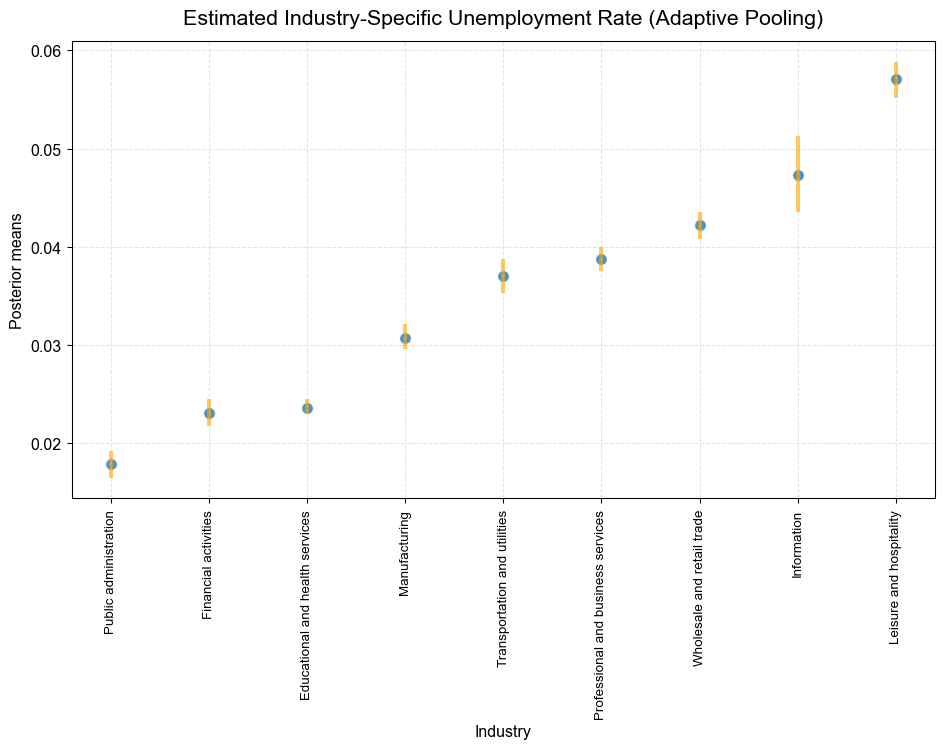

In [23]:
## 1. Exclude some industries and persons "not in labor force" and industries that don't have historical unemployment stats
survey_df_industry = survey_df[~survey_df['industry_name'].isin(['Construction',
                              'Mining',
                              'Other services',
                              'Agriculture, forestry, fishing, and hunting',
                              'Armed Forces'])]
survey_df_industry = survey_df_industry[survey_df_industry['employment_status_description']!="not in labor force"]
## Factorize the industry_name column to get numerical indices and names
industry_idx, industry_names = survey_df_industry['industry_name'].factorize()
survey_df_industry['industry_idx'] = industry_idx
## Map EmploymentStatus to numerical (0 for Employed, 1 for Unemployed)
survey_df_industry['unemployment_status'] = survey_df_industry['employment_status_description'].map({'employed': 0, 'unemployed': 1})

## 2. Get the prior means and sds of unemployment rates by industries from the historical monthly statistics (exlcuding 2020-2021)
df_industry_monthly_ur = df_industry[~df_industry['Industry'].isin(['construction',
                              'mining_quarrying_and_oil_and_gas_ extraction',
                              'other_services',
                              'agricultural',
                              'self_employed',
                              'non_durable_goods',
                              'durable_goods'])]

ur_by_industry = pd.DataFrame(df_industry_monthly_ur.groupby('Industry', as_index=False).agg(
    mean_ur = ('Unemployment_rate','mean'),
    sd_ur = ('Unemployment_rate', 'std')
))
 # modify the industry name column to align with industry_names
ur_by_industry['Industry']=['Educational and health services',
                            'Financial activities',
                            'Public administration',
                            'Information',
                            'Leisure and hospitality',
                            'Manufacturing',
                            'Professional and business services',
                            'Transportation and utilities',
                            'Wholesale and retail trade']
# Logit transformation function
def logit(p):
    return np.log(p / (1 - p))
ur_by_industry['mean_ur_logit'] = logit(ur_by_industry['mean_ur']/100)
ur_by_industry['sd_ur_logit'] = logit(ur_by_industry['sd_ur']/100)

## 3. Define the Adaptive pooling PyMC model
# priors
ur_by_industry_copy = ur_by_industry.copy()
ur_by_industry_copy = ur_by_industry_copy.set_index('Industry')
prior_mu_alpha_vals = np.array([ur_by_industry_copy.loc[ind, 'mean_ur_logit'] for ind in industry_names])
prior_sigma_alpha_vals = np.array([ur_by_industry_copy.loc[ind, 'sd_ur_logit'] for ind in industry_names])
# Define the PGM model
coords = {"industry": industry_names}
with pm.Model(coords=coords) as adaptive_unemployment_industry_model:
    industry_idx_obs = pm.Data("industry_idx_obs", survey_df_industry['industry_idx'].values, dims="obs_id")
    # Global Priors 
    sigma = pm.Exponential("sigma", 1) # standard deviation for alpha_industry
    # Industry-Specific Parameters - observed industry means
    mu_alpha_industry = pm.Data("mu_alpha_industry", prior_mu_alpha_vals, dims="industry") # history industry means
    alpha_industry = pm.Normal("alpha_industry", 
                                mu=mu_alpha_industry, # historical industry means
                                sigma=sigma,
                                dims="industry")
    # Probability of unemployment of each industry determined by alpha_industry
    p_unemployment = pm.Deterministic("p_unemployment", pm.invlogit(alpha_industry[industry_idx_obs]))
    # Observed data - unemployment status
    unemployment_status_observed = pm.Bernoulli("unemployment_status", 
                                            p=p_unemployment, 
                                            observed=survey_df_industry['unemployment_status'].values,
                                            dims="obs_id")

## 4.Visualize the PGM
pm.model_to_graphviz(adaptive_unemployment_industry_model)  

## 5.MCMC sampling and prediction
with adaptive_unemployment_industry_model:
    ur_industry_trace = pm.sample(tune = 500, draws=500, random_seed=5650)
# Pring summary of the trace
trace_alpha_summary = az.summary(
    ur_industry_trace,
    var_names=['alpha_industry'],
    kind="stats", 
    round_to=2
)
display(trace_alpha_summary)
# post mean
ur_industry_post_mean = ur_industry_trace.posterior.mean(dim=("chain", "draw"))
ur_industry_post_mean_iter = ur_industry_post_mean.sortby("alpha_industry")
ur_industry_post_mean_iter['alpha_prob'] = 1 / (1 + np.exp(-ur_industry_post_mean_iter['alpha_industry']))
ur_industry_post_mean.to_dataframe()
ur_industry_post_hdi = az.hdi(ur_industry_trace)
ur_industry_post_hdi_iter = ur_industry_post_hdi.sortby(ur_industry_post_mean_iter.alpha_industry)
ur_industry_post_hdi_iter['alpha_prob']=1 / (1 + np.exp(-ur_industry_post_hdi_iter['alpha_industry']))
ur_industry_post_hdi_iter.to_dataframe()
# Plot the posterior alpha_industry (mean of unemployment)
fig, ax = plt.subplots(figsize=(10, 8))
ur_industry_post_mean_iter.plot.scatter(x='industry', y="alpha_prob", ax=ax, alpha=0.8, s=80)
ax.vlines(
    np.arange(industry_names.size),
    ur_industry_post_hdi_iter.alpha_prob.sel(hdi="lower"),
    ur_industry_post_hdi_iter.alpha_prob.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
    linewidth=3
)
ax.grid(True, linestyle='--', alpha=0.6, color='lightgray')     
ax.tick_params(axis='x', labelsize=10, rotation=90)
ax.set_xlabel('Industry', fontsize = 12)
ax.set_ylabel('Posterior means', fontsize = 12)
ax.set_title("Estimated Industry-Specific Unemployment Rate (Adaptive Pooling)", y=1.02, fontsize=16)
plt.tight_layout() 
plt.show()

### PGM for recent graduates unemployment time effect
(stretch goal)

## References {.unnumbered}

::: {#refs}
:::